In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from prophet import Prophet
from sklearn.metrics import root_mean_squared_error

from gbnet.models.forecasting import Forecast


urls = [
    "https://raw.githubusercontent.com/facebook/prophet/main/examples/example_air_passengers.csv",
    "https://raw.githubusercontent.com/facebook/prophet/main/examples/example_pedestrians_covid.csv",
    "https://raw.githubusercontent.com/facebook/prophet/main/examples/example_pedestrians_multivariate.csv",
    "https://raw.githubusercontent.com/facebook/prophet/main/examples/example_retail_sales.csv",
    "https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_R.csv",
    "https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_R_outliers1.csv",
    "https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_R_outliers2.csv",
    "https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv",
    "https://raw.githubusercontent.com/facebook/prophet/main/examples/example_yosemite_temps.csv",
]

datasets = pd.DataFrame([
    {
        'name': url.split('/')[-1],
        'data': pd.read_csv(url),
        'url': url,
        'ycol': (
            'y' if not (url.split('/')[-1] == 'example_pedestrians_multivariate.csv')
            else 'location_4'
        )
    }
    for url in urls
])

n_trials = 500
results = []
for _ in range(n_trials):

    seed = 1110011 + _
    dataset = datasets.sample(1, random_state=seed)

    df = dataset['data'].iloc[0].copy()
    df['ds'] = pd.to_datetime(df['ds'])
    df['y'] = df[dataset['ycol']].copy()

    np.random.seed(seed)
    train_q = np.random.random()
    test_q = np.random.random()
    train_cutoff = df['ds'].quantile(train_q)
    test_cutoff = df[df['ds'] > train_cutoff]['ds'].quantile(test_q)

    train = df[(df['ds'] <= train_cutoff) & (df['y'].notnull())].reset_index(drop=True).copy()
    test = df[(df['ds'] > train_cutoff) & (df['ds'] <= test_cutoff) & (df['y'].notnull())].reset_index(drop=True).copy()

    #####        
    m = Forecast()
    m.fit(train, train['y'])
    test['gblinear_pred'] = m.predict(test)

    #####
    try:
        m = Forecast(
            module_type='LGBModule', params={
                'min_sum_hessian_in_leaf':0,
                'min_data_in_leaf':0
            },
            nrounds=50,
            linear_params={'min_hess': 0.001, 'lambd': 0.001, 'lr': 0.9}
        )
        m.fit(train, train['y'])
        test['gblinear_lightgbm_pred'] = m.predict(test)
    except:
        test['gblinear_lightgbm_pred'] = 0
    

    #####
    pm = Prophet()
    pm.fit(train)
    test['prophet_pred'] = pm.predict(test)['yhat']

    sel = test['y'].notnull()
    results.append({
        'name': dataset['name'].iloc[0],
        'train_q': train_q,
        'test_q': test_q,
        'rmse_gblinear_xgb': root_mean_squared_error(test[sel]['y'], test[sel]['gblinear_pred']),
        'rmse_gblinear_lgb': root_mean_squared_error(test[sel]['y'], test[sel]['gblinear_lightgbm_pred']),
        'rmse_prophet': root_mean_squared_error(test[sel]['y'], test[sel]['prophet_pred'])
    })
    print(results[-1])
        


/opt/miniconda3/envs/gbnet/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1729646995093/work/torch/csrc/autograd/engine.cpp:1206.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
18:17:24 - cmdstanpy - INFO - Chain [1] start processing
18:17:24 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.36154450577037167, 'test_q': 0.718858543708024, 'rmse_gblinear_xgb': 1769.7023819059907, 'rmse_gblinear_lgb': 1786.585736531539, 'rmse_prophet': 1390.337812264345}


18:17:25 - cmdstanpy - INFO - Chain [1] start processing
18:17:25 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.47691397640899424, 'test_q': 0.17470154458523302, 'rmse_gblinear_xgb': 616.7843608236894, 'rmse_gblinear_lgb': 560.500411971511, 'rmse_prophet': 685.07166279096}


18:17:25 - cmdstanpy - INFO - Chain [1] start processing
18:17:25 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_air_passengers.csv', 'train_q': 0.8149420505769133, 'test_q': 0.634997259423755, 'rmse_gblinear_xgb': 17.655253513495467, 'rmse_gblinear_lgb': 16.389050091425123, 'rmse_prophet': 38.034818054959125}


18:17:26 - cmdstanpy - INFO - Chain [1] start processing
18:17:26 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.34009498122281934, 'test_q': 0.26333177720673473, 'rmse_gblinear_xgb': 3554.1378535900767, 'rmse_gblinear_lgb': 3492.3710688669184, 'rmse_prophet': 5309.997614336435}


18:17:26 - cmdstanpy - INFO - Chain [1] start processing
18:17:26 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.26461690081195344, 'test_q': 0.8756406570624425, 'rmse_gblinear_xgb': 0.3763299843613993, 'rmse_gblinear_lgb': 0.40363281019137387, 'rmse_prophet': 3.299606013541546}


18:17:27 - cmdstanpy - INFO - Chain [1] start processing
18:17:27 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.26736798907282533, 'test_q': 0.8913320945289969, 'rmse_gblinear_xgb': 1.8047858005316626, 'rmse_gblinear_lgb': 1.7674103895334794, 'rmse_prophet': 3.4340960109494953}


18:17:27 - cmdstanpy - INFO - Chain [1] start processing
18:17:27 - cmdstanpy - INFO - Chain [1] done processing
18:17:28 - cmdstanpy - INFO - Chain [1] start processing
18:17:28 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.4533150225018253, 'test_q': 0.08827848002971306, 'rmse_gblinear_xgb': 0.31190162726000936, 'rmse_gblinear_lgb': 0.291348105452709, 'rmse_prophet': 0.4259582059620475}


18:17:28 - cmdstanpy - INFO - Chain [1] start processing
18:17:28 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.36059406278842776, 'test_q': 0.6983199051626379, 'rmse_gblinear_xgb': 25298.397773939494, 'rmse_gblinear_lgb': 25935.781847868908, 'rmse_prophet': 55783.15388696653}
{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.09996257307334011, 'test_q': 0.2626895456015583, 'rmse_gblinear_xgb': 1.0930749266319524, 'rmse_gblinear_lgb': 0.9225404351106454, 'rmse_prophet': 3.4164243519185025}


18:17:28 - cmdstanpy - INFO - Chain [1] start processing
18:17:28 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.6006873565526945, 'test_q': 0.5717640526384449, 'rmse_gblinear_xgb': 0.9603251686147248, 'rmse_gblinear_lgb': 1.006050391250855, 'rmse_prophet': 0.7301625346084678}


18:17:29 - cmdstanpy - INFO - Chain [1] start processing
18:17:29 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.8780028789171096, 'test_q': 0.8012755555701592, 'rmse_gblinear_xgb': 10424.4876459451, 'rmse_gblinear_lgb': 10420.175980466975, 'rmse_prophet': 9267.588569217138}


18:17:29 - cmdstanpy - INFO - Chain [1] start processing
18:17:29 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_air_passengers.csv', 'train_q': 0.5905939418469055, 'test_q': 0.8307385342639536, 'rmse_gblinear_xgb': 34.77005363045267, 'rmse_gblinear_lgb': 32.65280754876236, 'rmse_prophet': 37.65853798116382}


18:17:30 - cmdstanpy - INFO - Chain [1] start processing
18:17:30 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.45494504596231367, 'test_q': 0.6354685808548499, 'rmse_gblinear_xgb': 0.5508640556804952, 'rmse_gblinear_lgb': 0.5211142095443594, 'rmse_prophet': 2.476032043036885}


18:17:30 - cmdstanpy - INFO - Chain [1] start processing
18:17:30 - cmdstanpy - INFO - Chain [1] done processing
18:17:31 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_retail_sales.csv', 'train_q': 0.04712510638088152, 'test_q': 0.13457079577359177, 'rmse_gblinear_xgb': 11869.670926660405, 'rmse_gblinear_lgb': 6340.081771778759, 'rmse_prophet': 16803.910299209427}


18:17:31 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.12351988426469362, 'test_q': 0.03485195534863639, 'rmse_gblinear_xgb': 0.4123345528193955, 'rmse_gblinear_lgb': 0.6834207159633297, 'rmse_prophet': 0.6186748008797407}


18:17:31 - cmdstanpy - INFO - Chain [1] start processing
18:17:31 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.9404557529787951, 'test_q': 0.33690513544830103, 'rmse_gblinear_xgb': 0.42139669720649964, 'rmse_gblinear_lgb': 0.4279656870353409, 'rmse_prophet': 0.3486239766815148}


18:17:31 - cmdstanpy - INFO - Chain [1] start processing
18:17:32 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.4514044311458514, 'test_q': 0.23138669036744164, 'rmse_gblinear_xgb': 0.30640833114194704, 'rmse_gblinear_lgb': 0.28414319024620543, 'rmse_prophet': 1.1632821907581297}


18:17:32 - cmdstanpy - INFO - Chain [1] start processing
18:17:34 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.6771906705553609, 'test_q': 0.5555210928879987, 'rmse_gblinear_xgb': 11.848193051733562, 'rmse_gblinear_lgb': 11.623716318946391, 'rmse_prophet': 35.48585930698816}


18:17:35 - cmdstanpy - INFO - Chain [1] start processing
18:17:35 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.8309720566891656, 'test_q': 0.9267941824601164, 'rmse_gblinear_xgb': 0.29401862235473286, 'rmse_gblinear_lgb': 0.2829010586952783, 'rmse_prophet': 0.4107749956700627}


18:17:36 - cmdstanpy - INFO - Chain [1] start processing
18:17:36 - cmdstanpy - INFO - Chain [1] done processing
18:17:36 - cmdstanpy - INFO - Chain [1] start processing
18:17:36 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.07369986571662668, 'test_q': 0.13737885704688935, 'rmse_gblinear_xgb': 1199.0580352949944, 'rmse_gblinear_lgb': 1150.1036413101363, 'rmse_prophet': 1531.3817494091418}


18:17:36 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_retail_sales.csv', 'train_q': 0.6344908735630264, 'test_q': 0.9268711947493307, 'rmse_gblinear_xgb': 38999.96463548663, 'rmse_gblinear_lgb': 39136.09663257833, 'rmse_prophet': 64347.549840385465}


18:17:36 - cmdstanpy - INFO - Chain [1] done processing
18:17:36 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.18364342262992162, 'test_q': 0.26680316503831214, 'rmse_gblinear_xgb': 1.160655079189571, 'rmse_gblinear_lgb': 1.244862279910737, 'rmse_prophet': 1.5105198093780707}


18:17:36 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.15302892339195107, 'test_q': 0.9920106855854431, 'rmse_gblinear_xgb': 1.5615315991390937, 'rmse_gblinear_lgb': 1.6900134288722932, 'rmse_prophet': 12.783264598281885}


18:17:37 - cmdstanpy - INFO - Chain [1] start processing
18:17:37 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.5120729938154002, 'test_q': 0.9141037096056253, 'rmse_gblinear_xgb': 0.7238285057069604, 'rmse_gblinear_lgb': 0.7254166416958086, 'rmse_prophet': 0.4669112425222388}


18:17:38 - cmdstanpy - INFO - Chain [1] start processing
18:17:41 - cmdstanpy - INFO - Chain [1] done processing
18:17:41 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.8932914874694047, 'test_q': 0.21538824264631962, 'rmse_gblinear_xgb': 6.570185685898324, 'rmse_gblinear_lgb': 6.307975717455053, 'rmse_prophet': 6.054384915871334}


18:17:41 - cmdstanpy - INFO - Chain [1] done processing
18:17:41 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.13632926091446884, 'test_q': 0.9841496845217999, 'rmse_gblinear_xgb': 3346.280763657004, 'rmse_gblinear_lgb': 3316.532298315054, 'rmse_prophet': 3883.790106405246}


18:17:41 - cmdstanpy - INFO - Chain [1] done processing
18:17:42 - cmdstanpy - INFO - Chain [1] start processing
18:17:42 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.04979225964658485, 'test_q': 0.5249264712398497, 'rmse_gblinear_xgb': 30.626148113797672, 'rmse_gblinear_lgb': 32.01683392140929, 'rmse_prophet': 13.116326725229465}


18:17:43 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.14564512254045037, 'test_q': 0.6348466879500061, 'rmse_gblinear_xgb': 2859.4889646371357, 'rmse_gblinear_lgb': 2859.6527538717396, 'rmse_prophet': 1622.2903202877515}


18:17:43 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.0552691672479364, 'test_q': 0.7373791575945485, 'rmse_gblinear_xgb': 2222.762916819441, 'rmse_gblinear_lgb': 1736.316730663711, 'rmse_prophet': 10148.88628581173}


18:17:43 - cmdstanpy - INFO - Chain [1] start processing
18:17:43 - cmdstanpy - INFO - Chain [1] done processing
18:17:43 - cmdstanpy - INFO - Chain [1] start processing
18:17:43 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.7076548038946002, 'test_q': 0.33958585729123747, 'rmse_gblinear_xgb': 0.25409897800826, 'rmse_gblinear_lgb': 0.24662374729777656, 'rmse_prophet': 0.3585095565067163}


18:17:44 - cmdstanpy - INFO - Chain [1] start processing
18:17:44 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.5122783787474824, 'test_q': 0.13059068219086167, 'rmse_gblinear_xgb': 358.2558654681247, 'rmse_gblinear_lgb': 331.9498376835836, 'rmse_prophet': 391.14658827068723}
{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.07899575328144282, 'test_q': 0.9570300970725589, 'rmse_gblinear_xgb': 0.613916819905817, 'rmse_gblinear_lgb': 0.6521338384856873, 'rmse_prophet': 0.6504787327996964}


18:17:44 - cmdstanpy - INFO - Chain [1] start processing
18:17:44 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.7727242993704413, 'test_q': 0.6447003813269131, 'rmse_gblinear_xgb': 570.6806204798141, 'rmse_gblinear_lgb': 589.4240317305278, 'rmse_prophet': 575.8736659771209}


18:17:44 - cmdstanpy - INFO - Chain [1] start processing
18:17:45 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.4129228329291188, 'test_q': 0.06459714358536361, 'rmse_gblinear_xgb': 1.3083444483980062, 'rmse_gblinear_lgb': 1.3220517364669395, 'rmse_prophet': 0.5406551808943493}


18:17:45 - cmdstanpy - INFO - Chain [1] start processing
18:17:45 - cmdstanpy - INFO - Chain [1] done processing
18:17:45 - cmdstanpy - INFO - Chain [1] start processing
18:17:45 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.5072061352694912, 'test_q': 0.1975442317322813, 'rmse_gblinear_xgb': 0.13687607601733695, 'rmse_gblinear_lgb': 0.12167486658796642, 'rmse_prophet': 0.31250181856982195}
{'name': 'example_retail_sales.csv', 'train_q': 0.530083809657977, 'test_q': 0.8863101125207608, 'rmse_gblinear_xgb': 23521.351545797184, 'rmse_gblinear_lgb': 23157.207213478887, 'rmse_prophet': 26450.579113058444}


18:17:46 - cmdstanpy - INFO - Chain [1] start processing
18:17:50 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.9547773291519969, 'test_q': 0.8888011693195949, 'rmse_gblinear_xgb': 5.182835431475718, 'rmse_gblinear_lgb': 4.189703267078833, 'rmse_prophet': 4.060170323745832}


18:17:51 - cmdstanpy - INFO - Chain [1] start processing
18:17:51 - cmdstanpy - INFO - Chain [1] done processing
18:17:52 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.1463161919617798, 'test_q': 0.8402537018978046, 'rmse_gblinear_xgb': 28.799881634094, 'rmse_gblinear_lgb': 28.182409097802527, 'rmse_prophet': 77.26277589132266}


18:17:53 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_air_passengers.csv', 'train_q': 0.3957008621635133, 'test_q': 0.041027743585094534, 'rmse_gblinear_xgb': 20.73041522682851, 'rmse_gblinear_lgb': 19.406501763711816, 'rmse_prophet': 26.435498578737754}


18:17:53 - cmdstanpy - INFO - Chain [1] start processing
18:17:53 - cmdstanpy - INFO - Chain [1] done processing
18:17:54 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.05277383007188585, 'test_q': 0.5311931044189461, 'rmse_gblinear_xgb': 29.528401382828605, 'rmse_gblinear_lgb': 29.624720142568478, 'rmse_prophet': 13.524861858175603}


18:17:54 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.056746377682033056, 'test_q': 0.5650519082694532, 'rmse_gblinear_xgb': 931.0034160707316, 'rmse_gblinear_lgb': 1049.7458772363873, 'rmse_prophet': 9088.367717898227}


18:17:54 - cmdstanpy - INFO - Chain [1] start processing
18:17:54 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.49467547087848107, 'test_q': 0.3963564156177548, 'rmse_gblinear_xgb': 0.7019185537714665, 'rmse_gblinear_lgb': 0.7035532678857911, 'rmse_prophet': 0.7090669858399858}


18:17:55 - cmdstanpy - INFO - Chain [1] start processing
18:17:55 - cmdstanpy - INFO - Chain [1] done processing
18:17:55 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.8669279867575276, 'test_q': 0.4754813907752997, 'rmse_gblinear_xgb': 1.3057484016640266, 'rmse_gblinear_lgb': 1.3062242406808922, 'rmse_prophet': 1.3347177810136337}


18:17:55 - cmdstanpy - INFO - Chain [1] done processing
18:17:56 - cmdstanpy - INFO - Chain [1] start processing
18:17:56 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.9934492520253498, 'test_q': 0.4515359855290705, 'rmse_gblinear_xgb': 4453.90625, 'rmse_gblinear_lgb': 3169.90625, 'rmse_prophet': 8748.61904898932}
{'name': 'example_air_passengers.csv', 'train_q': 0.15332585776954044, 'test_q': 0.318690458281893, 'rmse_gblinear_xgb': 22.688470450487536, 'rmse_gblinear_lgb': 22.369237618150695, 'rmse_prophet': 30.7286304356684}


18:17:56 - cmdstanpy - INFO - Chain [1] start processing
18:17:56 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.7598780761038465, 'test_q': 0.31369501982757864, 'rmse_gblinear_xgb': 0.1393308609854144, 'rmse_gblinear_lgb': 0.14596570000249506, 'rmse_prophet': 0.4258470167095192}


18:17:57 - cmdstanpy - INFO - Chain [1] start processing
18:17:57 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.49476353577321264, 'test_q': 0.8553870967213846, 'rmse_gblinear_xgb': 0.672147103212437, 'rmse_gblinear_lgb': 0.5625492500668967, 'rmse_prophet': 2.1540560273966345}


18:17:57 - cmdstanpy - INFO - Chain [1] start processing
18:17:57 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.5063309153278962, 'test_q': 0.4174815831783151, 'rmse_gblinear_xgb': 19740.289028017698, 'rmse_gblinear_lgb': 19564.552402934518, 'rmse_prophet': 24574.850877578036}


18:17:57 - cmdstanpy - INFO - Chain [1] start processing
18:17:58 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.9792078714419982, 'test_q': 0.6108970518407236, 'rmse_gblinear_xgb': 0.8437223463890776, 'rmse_gblinear_lgb': 0.8570536087927538, 'rmse_prophet': 0.8729692904722901}


18:17:58 - cmdstanpy - INFO - Chain [1] start processing
18:17:58 - cmdstanpy - INFO - Chain [1] done processing
18:17:58 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.8449359234962108, 'test_q': 0.7980400020148636, 'rmse_gblinear_xgb': 0.2990315228356464, 'rmse_gblinear_lgb': 0.2786838853074891, 'rmse_prophet': 0.45624032297222056}


18:17:59 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.3252641880245426, 'test_q': 0.8284133612453439, 'rmse_gblinear_xgb': 0.28003154462146596, 'rmse_gblinear_lgb': 0.23864014643947193, 'rmse_prophet': 0.7225936951606795}


18:18:00 - cmdstanpy - INFO - Chain [1] start processing
18:18:03 - cmdstanpy - INFO - Chain [1] done processing
18:18:04 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.9790674051745788, 'test_q': 0.5215834767111868, 'rmse_gblinear_xgb': 2.6800072739709444, 'rmse_gblinear_lgb': 2.0880886507424035, 'rmse_prophet': 4.602051366917221}


18:18:04 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.28663260233752486, 'test_q': 0.35457263653104865, 'rmse_gblinear_xgb': 0.2583077364092759, 'rmse_gblinear_lgb': 0.2650713703163555, 'rmse_prophet': 0.6785425762288163}


18:18:04 - cmdstanpy - INFO - Chain [1] start processing
18:18:04 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.8530253123028693, 'test_q': 0.6744724661208106, 'rmse_gblinear_xgb': 0.31463735855921027, 'rmse_gblinear_lgb': 0.30225131335021305, 'rmse_prophet': 0.4587172819752498}


18:18:05 - cmdstanpy - INFO - Chain [1] start processing
18:18:05 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.48510866797456165, 'test_q': 0.8259005376081813, 'rmse_gblinear_xgb': 0.7913764253329326, 'rmse_gblinear_lgb': 0.7962086622809375, 'rmse_prophet': 0.9414318449055766}


18:18:05 - cmdstanpy - INFO - Chain [1] start processing
18:18:05 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.6176093425771796, 'test_q': 0.7086476216577724, 'rmse_gblinear_xgb': 21721.337802158672, 'rmse_gblinear_lgb': 21706.779518312374, 'rmse_prophet': 22691.486888144722}


18:18:06 - cmdstanpy - INFO - Chain [1] start processing
18:18:06 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.7459137146169986, 'test_q': 0.7544218330527438, 'rmse_gblinear_xgb': 0.6653381206724205, 'rmse_gblinear_lgb': 0.5824670008982136, 'rmse_prophet': 0.5420291966522822}


18:18:07 - cmdstanpy - INFO - Chain [1] start processing
18:18:07 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.6372809830143495, 'test_q': 0.2730337877814507, 'rmse_gblinear_xgb': 317.15065549721413, 'rmse_gblinear_lgb': 315.3054482905781, 'rmse_prophet': 444.2497632748291}


18:18:07 - cmdstanpy - INFO - Chain [1] start processing
18:18:07 - cmdstanpy - INFO - Chain [1] done processing
18:18:07 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.47949767678334754, 'test_q': 0.937529382985626, 'rmse_gblinear_xgb': 16636.054667618162, 'rmse_gblinear_lgb': 16680.595873599694, 'rmse_prophet': 21931.6843384114}


18:18:07 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_air_passengers.csv', 'train_q': 0.2515188417544164, 'test_q': 0.64497451662745, 'rmse_gblinear_xgb': 37.221681942267026, 'rmse_gblinear_lgb': 38.341232271934004, 'rmse_prophet': 29.80973888821351}


18:18:08 - cmdstanpy - INFO - Chain [1] start processing
18:18:08 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.4850580606828294, 'test_q': 0.5940616327070115, 'rmse_gblinear_xgb': 0.7163081718674004, 'rmse_gblinear_lgb': 0.7122689555484144, 'rmse_prophet': 0.7805432454488861}


18:18:08 - cmdstanpy - INFO - Chain [1] start processing
18:18:08 - cmdstanpy - INFO - Chain [1] done processing
18:18:09 - cmdstanpy - INFO - Chain [1] start processing
18:18:09 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.1452692914404332, 'test_q': 0.3887436257070468, 'rmse_gblinear_xgb': 0.836703341919076, 'rmse_gblinear_lgb': 0.7210809091305539, 'rmse_prophet': 3.263806312179085}
{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.35613159382593884, 'test_q': 0.7319798431333763, 'rmse_gblinear_xgb': 1854.5157268770677, 'rmse_gblinear_lgb': 1918.0057219201833, 'rmse_prophet': 1202.5890868103609}


18:18:09 - cmdstanpy - INFO - Chain [1] start processing
18:18:09 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.7589615156565378, 'test_q': 0.9224086438892427, 'rmse_gblinear_xgb': 1.0624670327392909, 'rmse_gblinear_lgb': 1.0651595183190388, 'rmse_prophet': 1.0420141446717393}


18:18:10 - cmdstanpy - INFO - Chain [1] start processing
18:18:10 - cmdstanpy - INFO - Chain [1] done processing
18:18:10 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.9163899669130753, 'test_q': 0.9798710885285155, 'rmse_gblinear_xgb': 18469.075654419437, 'rmse_gblinear_lgb': 18496.28339917804, 'rmse_prophet': 9116.320571032893}


18:18:10 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.8351772290641369, 'test_q': 0.13967035540560724, 'rmse_gblinear_xgb': 525.0181993867807, 'rmse_gblinear_lgb': 516.9660998149036, 'rmse_prophet': 526.6060934364122}


18:18:10 - cmdstanpy - INFO - Chain [1] start processing
18:18:10 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.3928309694367951, 'test_q': 0.8661594523038769, 'rmse_gblinear_xgb': 1.557252608906721, 'rmse_gblinear_lgb': 1.5637663047618489, 'rmse_prophet': 2.131105789218567}


18:18:11 - cmdstanpy - INFO - Chain [1] start processing
18:18:11 - cmdstanpy - INFO - Chain [1] done processing
18:18:11 - cmdstanpy - INFO - Chain [1] start processing
18:18:11 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.413373843257857, 'test_q': 0.22060217138962868, 'rmse_gblinear_xgb': 2958.3614610615064, 'rmse_gblinear_lgb': 2975.5792118547583, 'rmse_prophet': 4228.185744149026}


18:18:11 - cmdstanpy - INFO - Chain [1] start processing
18:18:11 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_air_passengers.csv', 'train_q': 0.9375140780977692, 'test_q': 0.8537925440428635, 'rmse_gblinear_xgb': 30.267336721994077, 'rmse_gblinear_lgb': 25.839044848086274, 'rmse_prophet': 54.2630492399097}


18:18:12 - cmdstanpy - INFO - Chain [1] start processing
18:18:12 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_air_passengers.csv', 'train_q': 0.07042759665711307, 'test_q': 0.15690694835525865, 'rmse_gblinear_xgb': 46.73222128955097, 'rmse_gblinear_lgb': 43.140455487958945, 'rmse_prophet': 29.742747137460793}


18:18:12 - cmdstanpy - INFO - Chain [1] start processing
18:18:12 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.3717815883805041, 'test_q': 0.8846814914857406, 'rmse_gblinear_xgb': 1684.510344416804, 'rmse_gblinear_lgb': 1781.8971950083967, 'rmse_prophet': 1252.6819222126965}


18:18:12 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.0760150258603689, 'test_q': 0.058865745357019494, 'rmse_gblinear_xgb': 0.5593589861203687, 'rmse_gblinear_lgb': 0.5859901014498545, 'rmse_prophet': 0.576691318801267}


18:18:12 - cmdstanpy - INFO - Chain [1] done processing
18:18:12 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.025475863185731584, 'test_q': 0.08921668358761381, 'rmse_gblinear_xgb': 15998.893410132507, 'rmse_gblinear_lgb': 16254.100513025502, 'rmse_prophet': 14651.646607184806}


18:18:12 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.3177285071692374, 'test_q': 0.22652392579398417, 'rmse_gblinear_xgb': 0.22339481717490337, 'rmse_gblinear_lgb': 0.23076141472020248, 'rmse_prophet': 0.38387159575633045}


[LightGBM] [Fatal] Check failed: (train_data->num_features()) > (0) at /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_0e15gqmeju/croot/lightgbm_1723565410808/work/src/treelearner/feature_histogram.hpp, line 1507 .

18:18:13 - cmdstanpy - INFO - Chain [1] start processing
18:18:13 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.0012859526386662656, 'test_q': 0.5162000358089706, 'rmse_gblinear_xgb': 1752891.6332876824, 'rmse_gblinear_lgb': 35421.952609182, 'rmse_prophet': 1748497.2268201928}


18:18:14 - cmdstanpy - INFO - Chain [1] start processing
18:18:18 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.9339253385218168, 'test_q': 0.4975367615326013, 'rmse_gblinear_xgb': 4.630597847060493, 'rmse_gblinear_lgb': 4.333901010505124, 'rmse_prophet': 5.52974787075036}


18:18:18 - cmdstanpy - INFO - Chain [1] start processing
18:18:19 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.8351048991796549, 'test_q': 0.9064537747325554, 'rmse_gblinear_xgb': 0.28707838984005374, 'rmse_gblinear_lgb': 0.2670613541626755, 'rmse_prophet': 0.4175675530010571}


18:18:19 - cmdstanpy - INFO - Chain [1] start processing
18:18:19 - cmdstanpy - INFO - Chain [1] done processing
18:18:20 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.07296950981394856, 'test_q': 0.5700354750181081, 'rmse_gblinear_xgb': 5.4253543810393765, 'rmse_gblinear_lgb': 6.918649098077549, 'rmse_prophet': 3.9157514291437043}


18:18:20 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.32944359228168063, 'test_q': 0.8953501880332766, 'rmse_gblinear_xgb': 19921.126007545852, 'rmse_gblinear_lgb': 19889.196039804297, 'rmse_prophet': 67715.4087995444}


18:18:20 - cmdstanpy - INFO - Chain [1] start processing
18:18:20 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.44476041073540107, 'test_q': 0.03932919616659103, 'rmse_gblinear_xgb': 0.19413905615186938, 'rmse_gblinear_lgb': 0.1158014950039208, 'rmse_prophet': 0.27450253945499226}


18:18:21 - cmdstanpy - INFO - Chain [1] start processing
18:18:24 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.9354629137089917, 'test_q': 0.07644570876961643, 'rmse_gblinear_xgb': 4.716524366189571, 'rmse_gblinear_lgb': 4.931638813854692, 'rmse_prophet': 8.072215189003442}


18:18:25 - cmdstanpy - INFO - Chain [1] start processing
18:18:25 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.46186432254552123, 'test_q': 0.5928809216584418, 'rmse_gblinear_xgb': 0.32156281467129005, 'rmse_gblinear_lgb': 0.30935802604782053, 'rmse_prophet': 0.5264051935699628}


18:18:25 - cmdstanpy - INFO - Chain [1] start processing
18:18:25 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.7360889591913221, 'test_q': 0.3973452701964506, 'rmse_gblinear_xgb': 0.5591508446386779, 'rmse_gblinear_lgb': 0.5767498571964316, 'rmse_prophet': 0.5612334575412783}


18:18:26 - cmdstanpy - INFO - Chain [1] start processing
18:18:26 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.4368395259999721, 'test_q': 0.343945890684904, 'rmse_gblinear_xgb': 0.25688758560089003, 'rmse_gblinear_lgb': 0.24678951274832805, 'rmse_prophet': 0.38492713256460837}


18:18:26 - cmdstanpy - INFO - Chain [1] start processing
18:18:26 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.1062312205740128, 'test_q': 0.2685774500601953, 'rmse_gblinear_xgb': 7080.923455687804, 'rmse_gblinear_lgb': 12076.328041824278, 'rmse_prophet': 13987.08190218205}


18:18:27 - cmdstanpy - INFO - Chain [1] start processing
18:18:27 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.7368784628779249, 'test_q': 0.5519194970365925, 'rmse_gblinear_xgb': 0.2779501350714209, 'rmse_gblinear_lgb': 0.2863770913032065, 'rmse_prophet': 0.4356823205281671}


18:18:27 - cmdstanpy - INFO - Chain [1] start processing
18:18:33 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.09677401432881161, 'test_q': 0.5622874983193619, 'rmse_gblinear_xgb': 8549.249766317105, 'rmse_gblinear_lgb': 9198.14694408252, 'rmse_prophet': 24117.561872698065}


18:18:34 - cmdstanpy - INFO - Chain [1] start processing
18:18:36 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.724111400507875, 'test_q': 0.8129457958488133, 'rmse_gblinear_xgb': 5.5356920863030386, 'rmse_gblinear_lgb': 5.779915343687867, 'rmse_prophet': 9.741681008121313}


18:18:37 - cmdstanpy - INFO - Chain [1] start processing
18:18:37 - cmdstanpy - INFO - Chain [1] done processing
18:18:38 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.8955411919870577, 'test_q': 0.16848439962533324, 'rmse_gblinear_xgb': 0.18530348057048643, 'rmse_gblinear_lgb': 0.13745527927437404, 'rmse_prophet': 0.32271145382983546}


18:18:38 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.37069833537623675, 'test_q': 0.45519011400288845, 'rmse_gblinear_xgb': 0.23524944068775083, 'rmse_gblinear_lgb': 0.23424064350008464, 'rmse_prophet': 1.0109673333625244}


18:18:38 - cmdstanpy - INFO - Chain [1] start processing
18:18:38 - cmdstanpy - INFO - Chain [1] done processing
18:18:39 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.5945921456000091, 'test_q': 0.0503917863971437, 'rmse_gblinear_xgb': 0.36473598718362404, 'rmse_gblinear_lgb': 0.34521438417829664, 'rmse_prophet': 0.5033083375378476}


18:18:39 - cmdstanpy - INFO - Chain [1] done processing
18:18:39 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_air_passengers.csv', 'train_q': 0.2508236480525342, 'test_q': 0.9862508730163353, 'rmse_gblinear_xgb': 57.84757289779077, 'rmse_gblinear_lgb': 59.58726448787769, 'rmse_prophet': 44.4313270487811}


18:18:39 - cmdstanpy - INFO - Chain [1] done processing
18:18:39 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_air_passengers.csv', 'train_q': 0.5540895378460023, 'test_q': 0.11835452322844653, 'rmse_gblinear_xgb': 13.921998413044129, 'rmse_gblinear_lgb': 13.445955954204116, 'rmse_prophet': 9.495298277283165}


18:18:39 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.30336467414180457, 'test_q': 0.5521000291264141, 'rmse_gblinear_xgb': 0.2774022457077425, 'rmse_gblinear_lgb': 0.30014804447935306, 'rmse_prophet': 1.502139150478881}


18:18:40 - cmdstanpy - INFO - Chain [1] start processing
18:18:40 - cmdstanpy - INFO - Chain [1] done processing
18:18:40 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_retail_sales.csv', 'train_q': 0.9848860297409703, 'test_q': 0.7706693874045425, 'rmse_gblinear_xgb': 6485.626789282091, 'rmse_gblinear_lgb': 6365.755131869728, 'rmse_prophet': 18128.515670354118}


18:18:40 - cmdstanpy - INFO - Chain [1] done processing
18:18:40 - cmdstanpy - INFO - Chain [1] start processing
18:18:40 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.4272160608910349, 'test_q': 0.33760414640003433, 'rmse_gblinear_xgb': 490.0385533745186, 'rmse_gblinear_lgb': 497.3411003108883, 'rmse_prophet': 456.0636247635132}


18:18:40 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_retail_sales.csv', 'train_q': 0.7842666069872781, 'test_q': 0.5511437762211666, 'rmse_gblinear_xgb': 21509.01232033292, 'rmse_gblinear_lgb': 21372.491988417023, 'rmse_prophet': 60078.17936939264}


18:18:40 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_air_passengers.csv', 'train_q': 0.2217831372406216, 'test_q': 0.03661736949966321, 'rmse_gblinear_xgb': 7.857453485630834, 'rmse_gblinear_lgb': 14.478571516625033, 'rmse_prophet': 9.068535146012643}


18:18:41 - cmdstanpy - INFO - Chain [1] start processing
18:18:41 - cmdstanpy - INFO - Chain [1] done processing
18:18:41 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.6915271983799737, 'test_q': 0.2446720214496605, 'rmse_gblinear_xgb': 0.35589819534830586, 'rmse_gblinear_lgb': 0.2968719629358904, 'rmse_prophet': 0.4450355375226761}


18:18:41 - cmdstanpy - INFO - Chain [1] done processing
18:18:41 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.2684273549190759, 'test_q': 0.9222711051756013, 'rmse_gblinear_xgb': 12891.871623604025, 'rmse_gblinear_lgb': 13045.752531418633, 'rmse_prophet': 20817.30571311977}


18:18:42 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.5089924518562772, 'test_q': 0.766900414157532, 'rmse_gblinear_xgb': 17580.86266531553, 'rmse_gblinear_lgb': 17634.53724167245, 'rmse_prophet': 17696.85484734075}


18:18:42 - cmdstanpy - INFO - Chain [1] start processing
18:18:42 - cmdstanpy - INFO - Chain [1] done processing
18:18:43 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.9095212552979048, 'test_q': 0.21552709382732538, 'rmse_gblinear_xgb': 2.008520430325459, 'rmse_gblinear_lgb': 1.993641235816586, 'rmse_prophet': 1.993728807582587}


18:18:43 - cmdstanpy - INFO - Chain [1] done processing
18:18:43 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_air_passengers.csv', 'train_q': 0.224349759125669, 'test_q': 0.34731521360876527, 'rmse_gblinear_xgb': 15.092578414014396, 'rmse_gblinear_lgb': 15.875210737235877, 'rmse_prophet': 20.935041139352972}


18:18:43 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.20212103559200267, 'test_q': 0.5537952400355256, 'rmse_gblinear_xgb': 0.8587755119559539, 'rmse_gblinear_lgb': 0.8832892546362371, 'rmse_prophet': 1.2038147672480697}


18:18:43 - cmdstanpy - INFO - Chain [1] start processing
18:18:44 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.8316324502644832, 'test_q': 0.5328387446283572, 'rmse_gblinear_xgb': 0.22550036335705662, 'rmse_gblinear_lgb': 0.2025027909574477, 'rmse_prophet': 0.38249242805284345}


18:18:44 - cmdstanpy - INFO - Chain [1] start processing
18:18:44 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.05909079263132644, 'test_q': 0.05024367268205865, 'rmse_gblinear_xgb': 1202.7445147357078, 'rmse_gblinear_lgb': 1208.9890043207122, 'rmse_prophet': 2779.579239756135}


18:18:44 - cmdstanpy - INFO - Chain [1] start processing
18:18:44 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.4236098312926998, 'test_q': 0.7101795629570811, 'rmse_gblinear_xgb': 0.44841501241962306, 'rmse_gblinear_lgb': 0.46134897682103565, 'rmse_prophet': 0.48664602844179666}


18:18:45 - cmdstanpy - INFO - Chain [1] start processing
18:18:45 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.15053890319253904, 'test_q': 0.8223916144282222, 'rmse_gblinear_xgb': 1.2838863541729728, 'rmse_gblinear_lgb': 1.2115265343799746, 'rmse_prophet': 2.692643982523125}


18:18:45 - cmdstanpy - INFO - Chain [1] start processing
18:18:45 - cmdstanpy - INFO - Chain [1] done processing
18:18:46 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.4838065986845125, 'test_q': 0.4612923042682189, 'rmse_gblinear_xgb': 12205.013675274606, 'rmse_gblinear_lgb': 12160.261138730497, 'rmse_prophet': 13744.92414411996}


18:18:46 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.39479046124483674, 'test_q': 0.15449451204784614, 'rmse_gblinear_xgb': 9774.265750555425, 'rmse_gblinear_lgb': 9840.662781894553, 'rmse_prophet': 13197.903533248224}


18:18:46 - cmdstanpy - INFO - Chain [1] start processing
18:18:46 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.7906928456048532, 'test_q': 0.9388327738375194, 'rmse_gblinear_xgb': 0.26136511479735625, 'rmse_gblinear_lgb': 0.24020936471417823, 'rmse_prophet': 0.4355514077940313}


18:18:47 - cmdstanpy - INFO - Chain [1] start processing
18:18:47 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.3548225100401263, 'test_q': 0.8334305112898105, 'rmse_gblinear_xgb': 1628.742090333466, 'rmse_gblinear_lgb': 1722.2255088756904, 'rmse_prophet': 1078.485510499995}


18:18:48 - cmdstanpy - INFO - Chain [1] start processing
18:18:49 - cmdstanpy - INFO - Chain [1] done processing
18:18:49 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.6455952881375179, 'test_q': 0.35531406842280644, 'rmse_gblinear_xgb': 12.352910443600107, 'rmse_gblinear_lgb': 12.721098104534766, 'rmse_prophet': 24.40158856996045}


18:18:49 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.16812316605912536, 'test_q': 0.9825132998018681, 'rmse_gblinear_xgb': 1.1349692122613564, 'rmse_gblinear_lgb': 1.1678207736017925, 'rmse_prophet': 3.065170488374695}


18:18:50 - cmdstanpy - INFO - Chain [1] start processing
18:18:53 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.8776756084310373, 'test_q': 0.6686882189408064, 'rmse_gblinear_xgb': 6.112614389012947, 'rmse_gblinear_lgb': 4.802298689393839, 'rmse_prophet': 7.03184630876104}


18:18:54 - cmdstanpy - INFO - Chain [1] start processing
18:18:54 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_air_passengers.csv', 'train_q': 0.5394501146818479, 'test_q': 0.9308650906549432, 'rmse_gblinear_xgb': 55.06283399643269, 'rmse_gblinear_lgb': 52.74206044739577, 'rmse_prophet': 62.872472393054146}


18:18:55 - cmdstanpy - INFO - Chain [1] start processing
18:18:56 - cmdstanpy - INFO - Chain [1] done processing
18:18:56 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.6556397157704014, 'test_q': 0.38952454174345796, 'rmse_gblinear_xgb': 13.291567823110707, 'rmse_gblinear_lgb': 12.71063739938539, 'rmse_prophet': 29.87621433738509}


18:18:57 - cmdstanpy - INFO - Chain [1] done processing
18:18:57 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_retail_sales.csv', 'train_q': 0.21003842804174622, 'test_q': 0.1351126894473319, 'rmse_gblinear_xgb': 5058.4303362925675, 'rmse_gblinear_lgb': 4870.414441418385, 'rmse_prophet': 5138.876132697307}


18:18:57 - cmdstanpy - INFO - Chain [1] done processing
18:18:57 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_air_passengers.csv', 'train_q': 0.6483127382245053, 'test_q': 0.2893324164635167, 'rmse_gblinear_xgb': 16.11125686836848, 'rmse_gblinear_lgb': 16.08350055770413, 'rmse_prophet': 34.11217351453959}


18:18:57 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.1961687107414143, 'test_q': 0.7551393089041386, 'rmse_gblinear_xgb': 0.8332743658254433, 'rmse_gblinear_lgb': 0.8488940803170573, 'rmse_prophet': 1.7164097707893726}


18:18:58 - cmdstanpy - INFO - Chain [1] start processing
18:18:58 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.459021437842708, 'test_q': 0.9590773656972511, 'rmse_gblinear_xgb': 526.614492606228, 'rmse_gblinear_lgb': 524.1547643510158, 'rmse_prophet': 644.4492931963608}


18:18:58 - cmdstanpy - INFO - Chain [1] start processing
18:18:59 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.34541615273492865, 'test_q': 0.16062559148125521, 'rmse_gblinear_xgb': 4.557878531313906, 'rmse_gblinear_lgb': 4.422325457588331, 'rmse_prophet': 16.835139182621056}


18:18:59 - cmdstanpy - INFO - Chain [1] start processing
18:19:00 - cmdstanpy - INFO - Chain [1] done processing
18:19:00 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.19454155485691627, 'test_q': 0.15944395105012987, 'rmse_gblinear_xgb': 12.876187365195552, 'rmse_gblinear_lgb': 13.03239776906279, 'rmse_prophet': 34.1558133142738}


18:19:00 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.6304982149213331, 'test_q': 0.1169819852534082, 'rmse_gblinear_xgb': 196.03751029716318, 'rmse_gblinear_lgb': 168.39264738821655, 'rmse_prophet': 300.6919283167609}


18:19:01 - cmdstanpy - INFO - Chain [1] start processing
18:19:02 - cmdstanpy - INFO - Chain [1] done processing
18:19:03 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.5540139498988923, 'test_q': 0.7082148460105531, 'rmse_gblinear_xgb': 8.594651538140429, 'rmse_gblinear_lgb': 8.567439966383501, 'rmse_prophet': 9.176455084530634}


18:19:03 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.06809627466436696, 'test_q': 0.24667288224468376, 'rmse_gblinear_xgb': 21.92254679012701, 'rmse_gblinear_lgb': 21.94074982190445, 'rmse_prophet': 22.527823461435176}


18:19:03 - cmdstanpy - INFO - Chain [1] start processing
18:19:04 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.5368693412845384, 'test_q': 0.4039797833263319, 'rmse_gblinear_xgb': 0.32851182417296815, 'rmse_gblinear_lgb': 0.3252535800106794, 'rmse_prophet': 0.7021699212374847}


18:19:04 - cmdstanpy - INFO - Chain [1] start processing
18:19:05 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.9512779883016261, 'test_q': 0.10500031400162435, 'rmse_gblinear_xgb': 0.0748273267739526, 'rmse_gblinear_lgb': 0.09651335295450109, 'rmse_prophet': 0.35067739545035376}


18:19:05 - cmdstanpy - INFO - Chain [1] start processing
18:19:05 - cmdstanpy - INFO - Chain [1] done processing
18:19:05 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.7306947005625709, 'test_q': 0.5871429957948165, 'rmse_gblinear_xgb': 7892.898839439492, 'rmse_gblinear_lgb': 8031.490505933373, 'rmse_prophet': 19347.784681745048}


18:19:05 - cmdstanpy - INFO - Chain [1] done processing
18:19:06 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.13568402806241742, 'test_q': 0.5194979599812515, 'rmse_gblinear_xgb': 1.377857135742401, 'rmse_gblinear_lgb': 1.2420613365259052, 'rmse_prophet': 5.630661356440469}


18:19:06 - cmdstanpy - INFO - Chain [1] done processing
18:19:06 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_air_passengers.csv', 'train_q': 0.5190937138132726, 'test_q': 0.8735402974677201, 'rmse_gblinear_xgb': 56.00485436793587, 'rmse_gblinear_lgb': 55.129486090464, 'rmse_prophet': 67.40545231766723}


18:19:06 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.5399890213456022, 'test_q': 0.4252871477749588, 'rmse_gblinear_xgb': 14726.574888884026, 'rmse_gblinear_lgb': 14662.084450031594, 'rmse_prophet': 15055.824648034306}


18:19:06 - cmdstanpy - INFO - Chain [1] start processing
18:19:07 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.646068063678432, 'test_q': 0.17674772179414444, 'rmse_gblinear_xgb': 0.2882945693758907, 'rmse_gblinear_lgb': 0.28308300646409723, 'rmse_prophet': 0.44622911662427733}


18:19:07 - cmdstanpy - INFO - Chain [1] start processing
18:19:07 - cmdstanpy - INFO - Chain [1] done processing
18:19:07 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.9156416852438949, 'test_q': 0.3120511318426693, 'rmse_gblinear_xgb': 2.996754928911226, 'rmse_gblinear_lgb': 2.963359336315767, 'rmse_prophet': 2.965938927574242}


18:19:07 - cmdstanpy - INFO - Chain [1] done processing
18:19:08 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_air_passengers.csv', 'train_q': 0.29707362743968, 'test_q': 0.467145503624526, 'rmse_gblinear_xgb': 19.723811846567198, 'rmse_gblinear_lgb': 19.898299863831244, 'rmse_prophet': 20.77523220146468}


18:19:08 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.4820254575819084, 'test_q': 0.3044993588317717, 'rmse_gblinear_xgb': 489.5947512785595, 'rmse_gblinear_lgb': 518.9330063707711, 'rmse_prophet': 468.25816084259804}


18:19:08 - cmdstanpy - INFO - Chain [1] start processing
18:19:08 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.5753497506659732, 'test_q': 0.9707769405887978, 'rmse_gblinear_xgb': 0.5091049266641136, 'rmse_gblinear_lgb': 0.5183105351312465, 'rmse_prophet': 0.4304468817627485}


18:19:09 - cmdstanpy - INFO - Chain [1] start processing
18:19:09 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.8632192756074799, 'test_q': 0.21196195097826798, 'rmse_gblinear_xgb': 0.2848199553222499, 'rmse_gblinear_lgb': 0.2568254606668288, 'rmse_prophet': 0.45776902989765117}


18:19:09 - cmdstanpy - INFO - Chain [1] start processing
18:19:10 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.7994084717212243, 'test_q': 0.9299768287821313, 'rmse_gblinear_xgb': 0.2700140216804241, 'rmse_gblinear_lgb': 0.24292399359612693, 'rmse_prophet': 0.4028469933038869}


18:19:10 - cmdstanpy - INFO - Chain [1] start processing
18:19:10 - cmdstanpy - INFO - Chain [1] done processing
18:19:11 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.6912794898995956, 'test_q': 0.1910160108463962, 'rmse_gblinear_xgb': 0.38060317958017603, 'rmse_gblinear_lgb': 0.2810483528322633, 'rmse_prophet': 0.5019672475466583}


18:19:11 - cmdstanpy - INFO - Chain [1] done processing
18:19:11 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.4333962358093847, 'test_q': 0.45165995330347675, 'rmse_gblinear_xgb': 394.3795253789187, 'rmse_gblinear_lgb': 388.8008418714591, 'rmse_prophet': 413.90167477955544}


18:19:11 - cmdstanpy - INFO - Chain [1] done processing
18:19:11 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_retail_sales.csv', 'train_q': 0.2932751146625663, 'test_q': 0.6400205653811385, 'rmse_gblinear_xgb': 20414.610575078856, 'rmse_gblinear_lgb': 20352.892417815186, 'rmse_prophet': 23176.90674155285}


18:19:11 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.14766572481125662, 'test_q': 0.47598277972030023, 'rmse_gblinear_xgb': 1.3693749630160175, 'rmse_gblinear_lgb': 1.426908982180339, 'rmse_prophet': 4.652462583546883}


18:19:12 - cmdstanpy - INFO - Chain [1] start processing
18:19:12 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.9906568624933697, 'test_q': 0.2414234747262105, 'rmse_gblinear_xgb': 0.17147665675264737, 'rmse_gblinear_lgb': 0.15863754662394, 'rmse_prophet': 0.48882026964796943}


18:19:12 - cmdstanpy - INFO - Chain [1] start processing
18:19:12 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.45455678568330726, 'test_q': 0.7208765601707727, 'rmse_gblinear_xgb': 0.714117577044059, 'rmse_gblinear_lgb': 0.7296270534629715, 'rmse_prophet': 0.7758804324880236}


18:19:13 - cmdstanpy - INFO - Chain [1] start processing
18:19:13 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.7668984238686031, 'test_q': 0.35770543635717256, 'rmse_gblinear_xgb': 0.14379532480709944, 'rmse_gblinear_lgb': 0.1594340936893748, 'rmse_prophet': 0.4518181193294085}


18:19:13 - cmdstanpy - INFO - Chain [1] start processing
18:19:14 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.9437404089735933, 'test_q': 0.20055401139604567, 'rmse_gblinear_xgb': 0.7046501875490206, 'rmse_gblinear_lgb': 0.5311057530571902, 'rmse_prophet': 0.7943943360357119}


18:19:14 - cmdstanpy - INFO - Chain [1] start processing
18:19:14 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.40441001210165595, 'test_q': 0.24213968723893875, 'rmse_gblinear_xgb': 1.077831724457579, 'rmse_gblinear_lgb': 1.108622335015015, 'rmse_prophet': 0.7264009449257911}


18:19:15 - cmdstanpy - INFO - Chain [1] start processing
18:19:15 - cmdstanpy - INFO - Chain [1] done processing
18:19:16 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.2253100582837133, 'test_q': 0.4553139882660241, 'rmse_gblinear_xgb': 15.251544496610872, 'rmse_gblinear_lgb': 15.824402244775973, 'rmse_prophet': 14.688586393667984}


18:19:16 - cmdstanpy - INFO - Chain [1] done processing
18:19:16 - cmdstanpy - INFO - Chain [1] start processing
18:19:16 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.2241126301129216, 'test_q': 0.07848897134069932, 'rmse_gblinear_xgb': 4351.039877165199, 'rmse_gblinear_lgb': 4288.977291610851, 'rmse_prophet': 3968.009806222675}


18:19:16 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.060169366617595976, 'test_q': 0.8498200728175688, 'rmse_gblinear_xgb': 1.808636809061163, 'rmse_gblinear_lgb': 2.6087755659501313, 'rmse_prophet': 39.08677080093993}


18:19:16 - cmdstanpy - INFO - Chain [1] done processing
18:19:17 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.7859670189432433, 'test_q': 0.5488910739993916, 'rmse_gblinear_xgb': 659.7778292728232, 'rmse_gblinear_lgb': 624.2444622270835, 'rmse_prophet': 618.6639447870888}


18:19:17 - cmdstanpy - INFO - Chain [1] done processing
18:19:17 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_retail_sales.csv', 'train_q': 0.976609370710344, 'test_q': 0.06921897498625829, 'rmse_gblinear_xgb': 591.0625, 'rmse_gblinear_lgb': 600.375, 'rmse_prophet': 11208.014679577784}


18:19:17 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_air_passengers.csv', 'train_q': 0.22342726366136534, 'test_q': 0.2567275855366047, 'rmse_gblinear_xgb': 12.902516609287467, 'rmse_gblinear_lgb': 16.469799958676216, 'rmse_prophet': 16.80456105920864}


18:19:17 - cmdstanpy - INFO - Chain [1] start processing
18:19:17 - cmdstanpy - INFO - Chain [1] done processing
18:19:18 - cmdstanpy - INFO - Chain [1] start processing
18:19:18 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.15927413826657266, 'test_q': 0.2840604062468006, 'rmse_gblinear_xgb': 10.101567396356883, 'rmse_gblinear_lgb': 10.033823484309552, 'rmse_prophet': 15.963579467154794}


18:19:18 - cmdstanpy - INFO - Chain [1] start processing
18:19:18 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_air_passengers.csv', 'train_q': 0.9348199230605716, 'test_q': 0.18372632502194408, 'rmse_gblinear_xgb': 17.950449721233877, 'rmse_gblinear_lgb': 16.81801131097847, 'rmse_prophet': 26.157914970045816}


18:19:18 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_air_passengers.csv', 'train_q': 0.08684404267336421, 'test_q': 0.36939431665305333, 'rmse_gblinear_xgb': 117.02821729547829, 'rmse_gblinear_lgb': 119.5392190063064, 'rmse_prophet': 84.41136922842342}


18:19:19 - cmdstanpy - INFO - Chain [1] done processing
18:19:19 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_retail_sales.csv', 'train_q': 0.8131970625748057, 'test_q': 0.45162571732419887, 'rmse_gblinear_xgb': 12953.229506123958, 'rmse_gblinear_lgb': 12953.39989715538, 'rmse_prophet': 42811.160307601946}


18:19:19 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.4374055188753774, 'test_q': 0.5292834325056006, 'rmse_gblinear_xgb': 20205.737890756976, 'rmse_gblinear_lgb': 20144.021005342023, 'rmse_prophet': 24227.485874805297}


18:19:19 - cmdstanpy - INFO - Chain [1] start processing
18:19:19 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.3992985491785145, 'test_q': 0.2524150585992182, 'rmse_gblinear_xgb': 1.071961190432036, 'rmse_gblinear_lgb': 1.1035139083125556, 'rmse_prophet': 0.7958154676975578}


18:19:20 - cmdstanpy - INFO - Chain [1] start processing
18:19:20 - cmdstanpy - INFO - Chain [1] done processing
18:19:20 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.31731705757164974, 'test_q': 0.36837897308775513, 'rmse_gblinear_xgb': 3499.068172459785, 'rmse_gblinear_lgb': 3525.7891455148924, 'rmse_prophet': 8664.928603127833}


18:19:20 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.9950606993115656, 'test_q': 0.2281043118507564, 'rmse_gblinear_xgb': 398.3072509765625, 'rmse_gblinear_lgb': 463.431884765625, 'rmse_prophet': 570.5020082336139}


18:19:20 - cmdstanpy - INFO - Chain [1] start processing
18:19:20 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.6881711669774369, 'test_q': 0.2556545420279156, 'rmse_gblinear_xgb': 19042.467392920225, 'rmse_gblinear_lgb': 18586.02582743906, 'rmse_prophet': 21533.910871160566}


18:19:20 - cmdstanpy - INFO - Chain [1] start processing
18:19:20 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.10470279649922243, 'test_q': 0.5568850202527862, 'rmse_gblinear_xgb': 4538.744136511269, 'rmse_gblinear_lgb': 4319.8937913775335, 'rmse_prophet': 4540.941346812286}


18:19:21 - cmdstanpy - INFO - Chain [1] start processing
18:19:21 - cmdstanpy - INFO - Chain [1] done processing
18:19:21 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.4886147872966454, 'test_q': 0.004323036746828213, 'rmse_gblinear_xgb': 1.3440691590016833, 'rmse_gblinear_lgb': 1.344870849095328, 'rmse_prophet': 1.149454344756704}


18:19:21 - cmdstanpy - INFO - Chain [1] done processing
18:19:21 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.04363450504130051, 'test_q': 0.5025793883478158, 'rmse_gblinear_xgb': 11472.153692146228, 'rmse_gblinear_lgb': 12423.374468185919, 'rmse_prophet': 44596.70599144005}


18:19:21 - cmdstanpy - INFO - Chain [1] done processing
18:19:22 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_retail_sales.csv', 'train_q': 0.9193393324355561, 'test_q': 0.29036765969117384, 'rmse_gblinear_xgb': 13159.276768162637, 'rmse_gblinear_lgb': 13382.178877685406, 'rmse_prophet': 5812.564805141932}


18:19:22 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.7117660902143733, 'test_q': 0.6460266109617804, 'rmse_gblinear_xgb': 17256.532702157216, 'rmse_gblinear_lgb': 17143.46368254939, 'rmse_prophet': 22167.751140752156}


18:19:22 - cmdstanpy - INFO - Chain [1] start processing
18:19:22 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.5445408270491431, 'test_q': 0.4526755469880164, 'rmse_gblinear_xgb': 0.3946697680664885, 'rmse_gblinear_lgb': 0.3337785528458698, 'rmse_prophet': 1.0152534169705707}


18:19:23 - cmdstanpy - INFO - Chain [1] start processing
18:19:23 - cmdstanpy - INFO - Chain [1] done processing
18:19:23 - cmdstanpy - INFO - Chain [1] start processing
18:19:23 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.5790779339953867, 'test_q': 0.33513317888961014, 'rmse_gblinear_xgb': 15697.398561749224, 'rmse_gblinear_lgb': 15692.58983074322, 'rmse_prophet': 16292.8885362586}


18:19:23 - cmdstanpy - INFO - Chain [1] start processing
18:19:23 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.11828988761891968, 'test_q': 0.5713417959095121, 'rmse_gblinear_xgb': 1.020873757343769, 'rmse_gblinear_lgb': 0.8942958571585378, 'rmse_prophet': 0.8582820050185463}


18:19:23 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_air_passengers.csv', 'train_q': 0.8859787772376994, 'test_q': 0.029274159859623006, 'rmse_gblinear_xgb': 27.7403564453125, 'rmse_gblinear_lgb': 22.882080078125, 'rmse_prophet': 78.27389238740545}


18:19:24 - cmdstanpy - INFO - Chain [1] done processing
18:19:24 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.658018275728813, 'test_q': 0.4080994303386679, 'rmse_gblinear_xgb': 22898.10607361138, 'rmse_gblinear_lgb': 23102.264390048298, 'rmse_prophet': 24393.651863217336}


18:19:24 - cmdstanpy - INFO - Chain [1] done processing
18:19:24 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.4780788540929942, 'test_q': 0.18126108130371543, 'rmse_gblinear_xgb': 601.3265382909368, 'rmse_gblinear_lgb': 577.5980227815154, 'rmse_prophet': 641.050953770535}


18:19:24 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.16907706060638894, 'test_q': 0.1635049044728044, 'rmse_gblinear_xgb': 5183.537137809617, 'rmse_gblinear_lgb': 5503.528134211177, 'rmse_prophet': 5264.445066615934}


18:19:24 - cmdstanpy - INFO - Chain [1] start processing
18:19:25 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.2321344538839294, 'test_q': 0.8070729528875568, 'rmse_gblinear_xgb': 26.397866955220653, 'rmse_gblinear_lgb': 25.323586909477793, 'rmse_prophet': 115.61465105945771}


18:19:26 - cmdstanpy - INFO - Chain [1] start processing
18:19:26 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.6743585554379709, 'test_q': 0.7153828413297892, 'rmse_gblinear_xgb': 0.3714415227830536, 'rmse_gblinear_lgb': 0.35478861903926395, 'rmse_prophet': 0.5044624386615293}


18:19:26 - cmdstanpy - INFO - Chain [1] start processing
18:19:27 - cmdstanpy - INFO - Chain [1] done processing
18:19:27 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.8469159759669506, 'test_q': 0.046309721591186515, 'rmse_gblinear_xgb': 554.0340066163243, 'rmse_gblinear_lgb': 570.0556340381972, 'rmse_prophet': 582.1767877453149}


18:19:27 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_air_passengers.csv', 'train_q': 0.8471992532201632, 'test_q': 0.35542718868053236, 'rmse_gblinear_xgb': 23.270483908553835, 'rmse_gblinear_lgb': 24.18356384501898, 'rmse_prophet': 38.5845095319658}


18:19:27 - cmdstanpy - INFO - Chain [1] start processing
18:19:27 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.5901060406314366, 'test_q': 0.5853290878338833, 'rmse_gblinear_xgb': 0.27995290930260763, 'rmse_gblinear_lgb': 0.2651724955795413, 'rmse_prophet': 0.3653711085378153}


18:19:28 - cmdstanpy - INFO - Chain [1] start processing
18:19:28 - cmdstanpy - INFO - Chain [1] done processing
18:19:28 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.7862262593205377, 'test_q': 0.5453041148871657, 'rmse_gblinear_xgb': 659.7778292728232, 'rmse_gblinear_lgb': 624.2444622270835, 'rmse_prophet': 618.6639447870888}


18:19:28 - cmdstanpy - INFO - Chain [1] done processing
18:19:28 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.23655419931462163, 'test_q': 0.036709928606777464, 'rmse_gblinear_xgb': 0.32969973689758564, 'rmse_gblinear_lgb': 0.3912900781469093, 'rmse_prophet': 0.36862522804872955}


18:19:28 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.2631195781009974, 'test_q': 0.42807878973172553, 'rmse_gblinear_xgb': 3543.1311692100517, 'rmse_gblinear_lgb': 3478.4267328428964, 'rmse_prophet': 17366.01879629038}


18:19:28 - cmdstanpy - INFO - Chain [1] start processing
18:19:28 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.3675537891209879, 'test_q': 0.16032016723604903, 'rmse_gblinear_xgb': 1.0283855271178115, 'rmse_gblinear_lgb': 1.0866856535280853, 'rmse_prophet': 2.597303199515853}


18:19:29 - cmdstanpy - INFO - Chain [1] start processing
18:19:29 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.5678610958810322, 'test_q': 0.484111138638334, 'rmse_gblinear_xgb': 0.33481039829533266, 'rmse_gblinear_lgb': 0.3076867023308597, 'rmse_prophet': 0.4207383783350789}


18:19:30 - cmdstanpy - INFO - Chain [1] start processing
18:19:30 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.73392156261893, 'test_q': 0.5812001971206063, 'rmse_gblinear_xgb': 0.6462749744420152, 'rmse_gblinear_lgb': 0.658232936435141, 'rmse_prophet': 0.541378479154138}


18:19:30 - cmdstanpy - INFO - Chain [1] start processing
18:19:30 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.5940906386518803, 'test_q': 0.5841626591287544, 'rmse_gblinear_xgb': 0.2824929644900999, 'rmse_gblinear_lgb': 0.27483311991487114, 'rmse_prophet': 0.383051056440565}


18:19:31 - cmdstanpy - INFO - Chain [1] start processing
18:19:31 - cmdstanpy - INFO - Chain [1] done processing
18:19:31 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_retail_sales.csv', 'train_q': 0.5363171726290439, 'test_q': 0.857265618529782, 'rmse_gblinear_xgb': 24990.038537856984, 'rmse_gblinear_lgb': 25041.414975419713, 'rmse_prophet': 31788.335647500015}


18:19:31 - cmdstanpy - INFO - Chain [1] done processing
18:19:31 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.5974530312232262, 'test_q': 0.1247092229670298, 'rmse_gblinear_xgb': 161.68397659813465, 'rmse_gblinear_lgb': 163.55259414441815, 'rmse_prophet': 244.16068588805487}


18:19:31 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.7962997956826287, 'test_q': 0.39392207445002936, 'rmse_gblinear_xgb': 12703.39348974893, 'rmse_gblinear_lgb': 12693.591982085849, 'rmse_prophet': 46711.1162296155}


18:19:32 - cmdstanpy - INFO - Chain [1] start processing
18:19:32 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.48912468600110215, 'test_q': 0.5720122321573154, 'rmse_gblinear_xgb': 0.3489194634184572, 'rmse_gblinear_lgb': 0.3336570479160293, 'rmse_prophet': 0.4231361737633774}


18:19:32 - cmdstanpy - INFO - Chain [1] start processing
18:19:32 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.5205042427170193, 'test_q': 0.49663348188263334, 'rmse_gblinear_xgb': 14537.225578292171, 'rmse_gblinear_lgb': 14526.998001971553, 'rmse_prophet': 14658.108828105433}


18:19:33 - cmdstanpy - INFO - Chain [1] start processing
18:19:33 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_air_passengers.csv', 'train_q': 0.23746861343720593, 'test_q': 0.7922928501333324, 'rmse_gblinear_xgb': 36.8710510238512, 'rmse_gblinear_lgb': 37.527205834549285, 'rmse_prophet': 31.49047451202917}


18:19:33 - cmdstanpy - INFO - Chain [1] start processing
18:19:33 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.3636458603336593, 'test_q': 0.2444215203056983, 'rmse_gblinear_xgb': 1.4132784628107626, 'rmse_gblinear_lgb': 1.4345000977145332, 'rmse_prophet': 3.5253753168826}


18:19:34 - cmdstanpy - INFO - Chain [1] start processing
18:19:34 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.6868217918394685, 'test_q': 0.403184948890135, 'rmse_gblinear_xgb': 0.6364120831425966, 'rmse_gblinear_lgb': 0.6158473410806634, 'rmse_prophet': 0.8640608617829821}


18:19:34 - cmdstanpy - INFO - Chain [1] start processing
18:19:35 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.2338815160016141, 'test_q': 0.7313205584979013, 'rmse_gblinear_xgb': 24.458557241742934, 'rmse_gblinear_lgb': 23.810687327828873, 'rmse_prophet': 85.10022231371327}


18:19:36 - cmdstanpy - INFO - Chain [1] start processing
18:19:37 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.5081887916277888, 'test_q': 0.1002398869020531, 'rmse_gblinear_xgb': 4.625358409482432, 'rmse_gblinear_lgb': 3.9955996621923955, 'rmse_prophet': 4.922778991675943}


18:19:38 - cmdstanpy - INFO - Chain [1] start processing
18:19:38 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_air_passengers.csv', 'train_q': 0.6485775435452512, 'test_q': 0.6591292041249518, 'rmse_gblinear_xgb': 18.28085187502803, 'rmse_gblinear_lgb': 18.193424708013257, 'rmse_prophet': 56.0178421263549}


18:19:38 - cmdstanpy - INFO - Chain [1] start processing
18:19:38 - cmdstanpy - INFO - Chain [1] done processing
18:19:39 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.8763115125491935, 'test_q': 0.928445091091791, 'rmse_gblinear_xgb': 0.30310159461014446, 'rmse_gblinear_lgb': 0.284784116133904, 'rmse_prophet': 0.4839535098207489}


18:19:39 - cmdstanpy - INFO - Chain [1] done processing
18:19:39 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.5741456002884032, 'test_q': 0.7148806720747127, 'rmse_gblinear_xgb': 397.6908547491527, 'rmse_gblinear_lgb': 386.25037177108055, 'rmse_prophet': 471.15018525245455}


18:19:39 - cmdstanpy - INFO - Chain [1] done processing
18:19:39 - cmdstanpy - INFO - Chain [1] start processing
18:19:39 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.5556316667342159, 'test_q': 0.24703539935551933, 'rmse_gblinear_xgb': 7501.534508259439, 'rmse_gblinear_lgb': 8063.7679426375325, 'rmse_prophet': 9223.296085729093}


18:19:39 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.04783849570746512, 'test_q': 0.0690416780993599, 'rmse_gblinear_xgb': 0.5481422457684079, 'rmse_gblinear_lgb': 0.6029145143737469, 'rmse_prophet': 1.216340871391196}


18:19:39 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.341893482646197, 'test_q': 0.8931961579513028, 'rmse_gblinear_xgb': 0.921599159683044, 'rmse_gblinear_lgb': 0.9095714182255459, 'rmse_prophet': 0.6144021584312696}


18:19:40 - cmdstanpy - INFO - Chain [1] start processing
18:19:40 - cmdstanpy - INFO - Chain [1] done processing
18:19:40 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_retail_sales.csv', 'train_q': 0.9476306974323085, 'test_q': 0.8602140442587762, 'rmse_gblinear_xgb': 5649.958460222392, 'rmse_gblinear_lgb': 5649.739631908126, 'rmse_prophet': 16114.73285756121}


18:19:40 - cmdstanpy - INFO - Chain [1] done processing
18:19:40 - cmdstanpy - INFO - Chain [1] start processing
18:19:40 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.40903001209578926, 'test_q': 0.43760137911855335, 'rmse_gblinear_xgb': 3568.2993460083067, 'rmse_gblinear_lgb': 3590.772175856824, 'rmse_prophet': 5901.175056374124}


18:19:41 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_air_passengers.csv', 'train_q': 0.043274036209271505, 'test_q': 0.27082319481641925, 'rmse_gblinear_xgb': 74.82072559687496, 'rmse_gblinear_lgb': 67.76250247369704, 'rmse_prophet': 77.27793121493735}


18:19:41 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.736448709288626, 'test_q': 0.10430966376850981, 'rmse_gblinear_xgb': 8620.229040989352, 'rmse_gblinear_lgb': 8904.338752965516, 'rmse_prophet': 7739.086556486296}


18:19:41 - cmdstanpy - INFO - Chain [1] start processing
18:19:41 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.7394155602490998, 'test_q': 0.9794220655905314, 'rmse_gblinear_xgb': 0.7690773926542874, 'rmse_gblinear_lgb': 0.7907534615132775, 'rmse_prophet': 0.5340782274145333}


18:19:42 - cmdstanpy - INFO - Chain [1] start processing
18:19:42 - cmdstanpy - INFO - Chain [1] done processing
18:19:42 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.24648573393598583, 'test_q': 0.47549688480787866, 'rmse_gblinear_xgb': 4158.285592378825, 'rmse_gblinear_lgb': 3993.171178856049, 'rmse_prophet': 8360.071425231583}


18:19:42 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.3474343056197039, 'test_q': 0.2915316510881333, 'rmse_gblinear_xgb': 0.23804452668809123, 'rmse_gblinear_lgb': 0.22941753348694813, 'rmse_prophet': 1.3328515254621542}


18:19:42 - cmdstanpy - INFO - Chain [1] start processing
18:19:42 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.20517259634117213, 'test_q': 0.8577657983183121, 'rmse_gblinear_xgb': 24004.894220989045, 'rmse_gblinear_lgb': 24238.755365598838, 'rmse_prophet': 17836.55490591806}


18:19:43 - cmdstanpy - INFO - Chain [1] start processing
18:19:43 - cmdstanpy - INFO - Chain [1] done processing
18:19:43 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.9642230592107358, 'test_q': 0.5501649023333917, 'rmse_gblinear_xgb': 0.21015121490478242, 'rmse_gblinear_lgb': 0.08376510038610421, 'rmse_prophet': 0.6598178128613611}


18:19:43 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.5092967696112792, 'test_q': 0.63043837295424, 'rmse_gblinear_xgb': 24815.271610013824, 'rmse_gblinear_lgb': 24795.459642340484, 'rmse_prophet': 21850.0724306909}


18:19:43 - cmdstanpy - INFO - Chain [1] start processing
18:19:44 - cmdstanpy - INFO - Chain [1] done processing
18:19:44 - cmdstanpy - INFO - Chain [1] start processing
18:19:44 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.9610472787081453, 'test_q': 0.8794240558373766, 'rmse_gblinear_xgb': 0.1650634725719661, 'rmse_gblinear_lgb': 0.12360319694594471, 'rmse_prophet': 0.3828271715752657}
{'name': 'example_wp_log_R.csv', 'train_q': 0.06363807115987308, 'test_q': 0.6899415211756966, 'rmse_gblinear_xgb': 0.6074285896414701, 'rmse_gblinear_lgb': 1.62588376392237, 'rmse_prophet': 6.3276887276051275}


18:19:45 - cmdstanpy - INFO - Chain [1] start processing
18:19:45 - cmdstanpy - INFO - Chain [1] done processing
18:19:45 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.768779168575806, 'test_q': 0.9845493906012389, 'rmse_gblinear_xgb': 624.5456190370369, 'rmse_gblinear_lgb': 638.8665045668301, 'rmse_prophet': 630.1170668678794}


18:19:45 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.3557814484758631, 'test_q': 0.9819396219594667, 'rmse_gblinear_xgb': 1603.4315410588188, 'rmse_gblinear_lgb': 1700.5271387906673, 'rmse_prophet': 1131.7636386241593}


18:19:45 - cmdstanpy - INFO - Chain [1] start processing
18:19:46 - cmdstanpy - INFO - Chain [1] done processing
18:19:46 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.875214269935171, 'test_q': 0.1666634557925324, 'rmse_gblinear_xgb': 0.19081898197586766, 'rmse_gblinear_lgb': 0.18422883798726566, 'rmse_prophet': 0.32789576760824546}


18:19:46 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.03056957576904462, 'test_q': 0.7051502458078984, 'rmse_gblinear_xgb': 2.4213813547199856, 'rmse_gblinear_lgb': 1.8868342295467846, 'rmse_prophet': 1.3716677015478045}


18:19:47 - cmdstanpy - INFO - Chain [1] start processing
18:19:47 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.2700380776975534, 'test_q': 0.6187121924747216, 'rmse_gblinear_xgb': 2.5520448279568786, 'rmse_gblinear_lgb': 2.5653401909019915, 'rmse_prophet': 12.467746331311364}


18:19:47 - cmdstanpy - INFO - Chain [1] start processing
18:19:48 - cmdstanpy - INFO - Chain [1] done processing
18:19:48 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.9863139275379939, 'test_q': 0.07256885973212945, 'rmse_gblinear_xgb': 0.0847814907671881, 'rmse_gblinear_lgb': 0.10344750296072262, 'rmse_prophet': 0.39912019771113466}


18:19:48 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.31794222027342134, 'test_q': 0.5140606169147347, 'rmse_gblinear_xgb': 0.22185210505036887, 'rmse_gblinear_lgb': 0.23526575802021607, 'rmse_prophet': 0.37240122754273847}


18:19:48 - cmdstanpy - INFO - Chain [1] start processing
18:19:49 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_air_passengers.csv', 'train_q': 0.5503065193441885, 'test_q': 0.501561964338512, 'rmse_gblinear_xgb': 26.236998566008886, 'rmse_gblinear_lgb': 24.67816960373712, 'rmse_prophet': 38.72565552573069}


18:19:49 - cmdstanpy - INFO - Chain [1] start processing
18:19:49 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.4807629871279102, 'test_q': 0.49316648716528955, 'rmse_gblinear_xgb': 0.29904524324456566, 'rmse_gblinear_lgb': 0.27866046893182567, 'rmse_prophet': 0.35443255323539813}


18:19:49 - cmdstanpy - INFO - Chain [1] start processing
18:19:49 - cmdstanpy - INFO - Chain [1] done processing
18:19:50 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.3228405743093544, 'test_q': 0.6109077698093889, 'rmse_gblinear_xgb': 10289.761221322216, 'rmse_gblinear_lgb': 10196.344899935486, 'rmse_prophet': 10353.732301134996}


18:19:50 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_air_passengers.csv', 'train_q': 0.4472122985142031, 'test_q': 0.217027252422771, 'rmse_gblinear_xgb': 23.712421638133343, 'rmse_gblinear_lgb': 26.577697496180836, 'rmse_prophet': 43.86372288753516}


18:19:50 - cmdstanpy - INFO - Chain [1] start processing
18:19:50 - cmdstanpy - INFO - Chain [1] done processing
18:19:51 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.855353435666053, 'test_q': 0.41500142578502996, 'rmse_gblinear_xgb': 0.25206363339849097, 'rmse_gblinear_lgb': 0.2264040191668098, 'rmse_prophet': 0.4316760706888063}


18:19:51 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.22346024095522155, 'test_q': 0.7785090075857033, 'rmse_gblinear_xgb': 0.6957162868869958, 'rmse_gblinear_lgb': 0.7368585696805006, 'rmse_prophet': 0.6736103025365974}


18:19:51 - cmdstanpy - INFO - Chain [1] start processing
18:19:51 - cmdstanpy - INFO - Chain [1] done processing
18:19:51 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.15516571261720813, 'test_q': 0.4412465676441939, 'rmse_gblinear_xgb': 1.3163347757378843, 'rmse_gblinear_lgb': 1.2633427834505107, 'rmse_prophet': 6.536860891155876}


18:19:51 - cmdstanpy - INFO - Chain [1] done processing
18:19:52 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.29579322545481557, 'test_q': 0.06468580682004466, 'rmse_gblinear_xgb': 0.3989287488123146, 'rmse_gblinear_lgb': 0.39930809361467373, 'rmse_prophet': 0.5804535795060614}


18:19:52 - cmdstanpy - INFO - Chain [1] done processing
18:19:52 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.5775689612451289, 'test_q': 0.8175290594834013, 'rmse_gblinear_xgb': 395.5089126209916, 'rmse_gblinear_lgb': 403.4511905837432, 'rmse_prophet': 475.72179378602766}


18:19:52 - cmdstanpy - INFO - Chain [1] done processing
18:19:52 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_retail_sales.csv', 'train_q': 0.8733390808808056, 'test_q': 0.5801760642364144, 'rmse_gblinear_xgb': 12635.656779839563, 'rmse_gblinear_lgb': 12884.464362839117, 'rmse_prophet': 12482.250550344004}


18:19:52 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.4272229680583556, 'test_q': 0.11485027841816164, 'rmse_gblinear_xgb': 387.63363169744196, 'rmse_gblinear_lgb': 416.2187564679905, 'rmse_prophet': 646.4709149380888}


18:19:52 - cmdstanpy - INFO - Chain [1] start processing
18:19:53 - cmdstanpy - INFO - Chain [1] done processing
18:19:53 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.7706932414395614, 'test_q': 0.24675578678090926, 'rmse_gblinear_xgb': 0.14609940071869304, 'rmse_gblinear_lgb': 0.14628065100311857, 'rmse_prophet': 0.39241547864770193}


18:19:53 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.23305583721781786, 'test_q': 0.5532856774664824, 'rmse_gblinear_xgb': 1140.4194972452199, 'rmse_gblinear_lgb': 1200.119522026929, 'rmse_prophet': 1728.5149124200195}


18:19:53 - cmdstanpy - INFO - Chain [1] start processing
18:19:53 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.5579401557153015, 'test_q': 0.7134573303596414, 'rmse_gblinear_xgb': 0.9376766196375631, 'rmse_gblinear_lgb': 0.9384219531743648, 'rmse_prophet': 1.6231763370767924}


18:19:54 - cmdstanpy - INFO - Chain [1] start processing
18:19:54 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.3125539821814175, 'test_q': 0.24943250178242193, 'rmse_gblinear_xgb': 3669.2340966495235, 'rmse_gblinear_lgb': 3691.3917866737297, 'rmse_prophet': 8048.506978773006}


18:19:54 - cmdstanpy - INFO - Chain [1] start processing
18:19:54 - cmdstanpy - INFO - Chain [1] done processing
18:19:54 - cmdstanpy - INFO - Chain [1] start processing
18:19:54 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.9878213613084074, 'test_q': 0.895323824672174, 'rmse_gblinear_xgb': 5898.36462141887, 'rmse_gblinear_lgb': 4231.094707094858, 'rmse_prophet': 4403.485913558423}
{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.07391857170209448, 'test_q': 0.620576014960128, 'rmse_gblinear_xgb': 0.7405116478445678, 'rmse_gblinear_lgb': 0.4222257066926057, 'rmse_prophet': 0.43372218301886417}


18:19:55 - cmdstanpy - INFO - Chain [1] start processing
18:19:55 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.9467899275454464, 'test_q': 0.2343466355286733, 'rmse_gblinear_xgb': 0.10392663467388098, 'rmse_gblinear_lgb': 0.09550118036850698, 'rmse_prophet': 0.37951282380611573}


18:19:56 - cmdstanpy - INFO - Chain [1] start processing
18:19:56 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.5871256290981703, 'test_q': 0.9659176021120214, 'rmse_gblinear_xgb': 0.5632955401634488, 'rmse_gblinear_lgb': 0.5754377027529476, 'rmse_prophet': 0.539837304712302}


18:19:56 - cmdstanpy - INFO - Chain [1] start processing
18:19:57 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.626548623043063, 'test_q': 0.9162254349660469, 'rmse_gblinear_xgb': 0.4371686084095109, 'rmse_gblinear_lgb': 0.4794226625157826, 'rmse_prophet': 0.7197059592879651}


18:19:57 - cmdstanpy - INFO - Chain [1] start processing
18:19:57 - cmdstanpy - INFO - Chain [1] done processing
18:19:59 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.055306003576441554, 'test_q': 0.8526841608422263, 'rmse_gblinear_xgb': 42.15055471544962, 'rmse_gblinear_lgb': 41.431201600028885, 'rmse_prophet': 10.654204013940056}


18:19:59 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.3252666759351249, 'test_q': 0.830426537848051, 'rmse_gblinear_xgb': 0.2806147284089252, 'rmse_gblinear_lgb': 0.23894515360701107, 'rmse_prophet': 0.7249697641187007}


18:19:59 - cmdstanpy - INFO - Chain [1] start processing
18:19:59 - cmdstanpy - INFO - Chain [1] done processing
18:19:59 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.4817321936078467, 'test_q': 0.5374700916797107, 'rmse_gblinear_xgb': 13563.315358466769, 'rmse_gblinear_lgb': 13501.77782325162, 'rmse_prophet': 16388.92155279548}


18:19:59 - cmdstanpy - INFO - Chain [1] done processing
18:20:00 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_air_passengers.csv', 'train_q': 0.7749450486034044, 'test_q': 0.3307016675260732, 'rmse_gblinear_xgb': 18.3792169513404, 'rmse_gblinear_lgb': 17.78142595868307, 'rmse_prophet': 40.272359507017086}


18:20:00 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.09108229557381753, 'test_q': 0.8789694765979674, 'rmse_gblinear_xgb': 1.0350963555969666, 'rmse_gblinear_lgb': 1.096906487944964, 'rmse_prophet': 2.4912246878806035}


18:20:00 - cmdstanpy - INFO - Chain [1] start processing
18:20:00 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.7129075914161327, 'test_q': 0.9516117903277382, 'rmse_gblinear_xgb': 0.33013821033253554, 'rmse_gblinear_lgb': 0.32345976329911713, 'rmse_prophet': 0.407642121425911}


18:20:01 - cmdstanpy - INFO - Chain [1] start processing
18:20:01 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.22523580061656312, 'test_q': 0.4192710488331254, 'rmse_gblinear_xgb': 0.42027140877265506, 'rmse_gblinear_lgb': 0.44579621733843355, 'rmse_prophet': 0.44452931790676997}


18:20:01 - cmdstanpy - INFO - Chain [1] start processing
18:20:02 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.19940068119459475, 'test_q': 0.5519607512966171, 'rmse_gblinear_xgb': 15.941444062892497, 'rmse_gblinear_lgb': 15.706520565525555, 'rmse_prophet': 81.50895582615578}


18:20:03 - cmdstanpy - INFO - Chain [1] start processing
18:20:03 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.3319524637874808, 'test_q': 0.9693347071635718, 'rmse_gblinear_xgb': 0.7878851653904919, 'rmse_gblinear_lgb': 0.7140196422318249, 'rmse_prophet': 1.6509747127087515}


18:20:03 - cmdstanpy - INFO - Chain [1] start processing
18:20:03 - cmdstanpy - INFO - Chain [1] done processing
18:20:03 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.48454502096628704, 'test_q': 0.740988176468723, 'rmse_gblinear_xgb': 499.7197248511526, 'rmse_gblinear_lgb': 535.9884267092049, 'rmse_prophet': 628.9353864603462}


18:20:04 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.4628309177550529, 'test_q': 0.7107607564558437, 'rmse_gblinear_xgb': 450.9599932806177, 'rmse_gblinear_lgb': 438.18253108113606, 'rmse_prophet': 709.0177964742286}


18:20:04 - cmdstanpy - INFO - Chain [1] start processing
18:20:04 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.4873773766984467, 'test_q': 0.171815756254183, 'rmse_gblinear_xgb': 0.2625631922978346, 'rmse_gblinear_lgb': 0.24753614329079848, 'rmse_prophet': 0.37124348736728174}


18:20:04 - cmdstanpy - INFO - Chain [1] start processing
18:20:04 - cmdstanpy - INFO - Chain [1] done processing
18:20:05 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.8509174648664166, 'test_q': 0.08482581320020066, 'rmse_gblinear_xgb': 0.14320153087552961, 'rmse_gblinear_lgb': 0.12399795085626446, 'rmse_prophet': 0.33834799116372993}


18:20:05 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.32977819201444203, 'test_q': 0.7509826367982034, 'rmse_gblinear_xgb': 0.30122396588204897, 'rmse_gblinear_lgb': 0.25024781290120396, 'rmse_prophet': 0.8638535551485235}


18:20:05 - cmdstanpy - INFO - Chain [1] start processing
18:20:05 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.594459329225468, 'test_q': 0.7203173413374782, 'rmse_gblinear_xgb': 20731.399894945265, 'rmse_gblinear_lgb': 20713.031555841633, 'rmse_prophet': 21400.221843874235}


18:20:06 - cmdstanpy - INFO - Chain [1] start processing
18:20:06 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.8729252866200843, 'test_q': 0.20377542003879012, 'rmse_gblinear_xgb': 7884.645057909011, 'rmse_gblinear_lgb': 7513.285279265127, 'rmse_prophet': 9251.114837785579}


18:20:06 - cmdstanpy - INFO - Chain [1] start processing
18:20:06 - cmdstanpy - INFO - Chain [1] done processing
18:20:07 - cmdstanpy - INFO - Chain [1] start processing
18:20:07 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.18952714152304817, 'test_q': 0.6388257766317867, 'rmse_gblinear_xgb': 16.1901051876692, 'rmse_gblinear_lgb': 15.888043555195454, 'rmse_prophet': 101.15664053870672}


18:20:08 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_retail_sales.csv', 'train_q': 0.03040881030299325, 'test_q': 0.31985761186261075, 'rmse_gblinear_xgb': 54937.15198088837, 'rmse_gblinear_lgb': 16722.344873216243, 'rmse_prophet': 74484.45446897906}


18:20:08 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.9473800116579507, 'test_q': 0.6348081638483295, 'rmse_gblinear_xgb': 4897.306122334949, 'rmse_gblinear_lgb': 4897.442492663422, 'rmse_prophet': 13154.669647383393}


18:20:08 - cmdstanpy - INFO - Chain [1] start processing
18:20:08 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.9362470147870167, 'test_q': 0.9111482354741284, 'rmse_gblinear_xgb': 4.18866327265317, 'rmse_gblinear_lgb': 4.261281697522604, 'rmse_prophet': 0.8570775210593623}


18:20:08 - cmdstanpy - INFO - Chain [1] start processing
18:20:08 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.7394288173015175, 'test_q': 0.7209452229310246, 'rmse_gblinear_xgb': 0.6588651191174536, 'rmse_gblinear_lgb': 0.6709480320896781, 'rmse_prophet': 0.5247428814989533}


18:20:09 - cmdstanpy - INFO - Chain [1] start processing
18:20:09 - cmdstanpy - INFO - Chain [1] done processing
18:20:09 - cmdstanpy - INFO - Chain [1] start processing
18:20:09 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_air_passengers.csv', 'train_q': 0.9521004110676389, 'test_q': 0.48638041946872235, 'rmse_gblinear_xgb': 31.327518261450905, 'rmse_gblinear_lgb': 31.320524180351065, 'rmse_prophet': 78.93117662271636}
{'name': 'example_retail_sales.csv', 'train_q': 0.030459312975266717, 'test_q': 0.8214718512356802, 'rmse_gblinear_xgb': 140773.98760872261, 'rmse_gblinear_lgb': 31658.824154252427, 'rmse_prophet': 178971.46144057458}


18:20:09 - cmdstanpy - INFO - Chain [1] start processing
18:20:10 - cmdstanpy - INFO - Chain [1] done processing
18:20:10 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.9550588422544026, 'test_q': 0.19064751378859224, 'rmse_gblinear_xgb': 7415.113414738748, 'rmse_gblinear_lgb': 4865.002528428702, 'rmse_prophet': 4700.9301174856055}


18:20:10 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.02490627615967933, 'test_q': 0.9356233559985211, 'rmse_gblinear_xgb': 137557.4238686709, 'rmse_gblinear_lgb': 143311.1963471188, 'rmse_prophet': 287426.3159541671}


18:20:11 - cmdstanpy - INFO - Chain [1] start processing
18:20:13 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.7266640043394024, 'test_q': 0.8087051631770246, 'rmse_gblinear_xgb': 5.639062734465262, 'rmse_gblinear_lgb': 5.57943663636923, 'rmse_prophet': 9.0360114575562}


18:20:13 - cmdstanpy - INFO - Chain [1] start processing
18:20:13 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.6238721729037895, 'test_q': 0.777517520775668, 'rmse_gblinear_xgb': 21723.540093848125, 'rmse_gblinear_lgb': 21716.324316185368, 'rmse_prophet': 22702.770952199375}


18:20:14 - cmdstanpy - INFO - Chain [1] start processing
18:20:14 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.015845975877363472, 'test_q': 0.810967882505409, 'rmse_gblinear_xgb': 755190.3532516723, 'rmse_gblinear_lgb': 868744.1999401144, 'rmse_prophet': 738117.0961258664}


18:20:14 - cmdstanpy - INFO - Chain [1] start processing
18:20:15 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.9092819417970647, 'test_q': 0.8075136694835144, 'rmse_gblinear_xgb': 0.31862243552224123, 'rmse_gblinear_lgb': 0.27131201462577104, 'rmse_prophet': 0.4626295304142598}


18:20:15 - cmdstanpy - INFO - Chain [1] start processing
18:20:17 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.5230586415038662, 'test_q': 0.9035725671268237, 'rmse_gblinear_xgb': 7.333098682805815, 'rmse_gblinear_lgb': 7.803003306045594, 'rmse_prophet': 9.73513130204286}


18:20:18 - cmdstanpy - INFO - Chain [1] start processing
18:20:18 - cmdstanpy - INFO - Chain [1] done processing
18:20:19 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.30689513379269007, 'test_q': 0.5665217886918381, 'rmse_gblinear_xgb': 10.979190383575368, 'rmse_gblinear_lgb': 11.054701114005791, 'rmse_prophet': 90.98686050586922}


18:20:19 - cmdstanpy - INFO - Chain [1] done processing
18:20:20 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_air_passengers.csv', 'train_q': 0.42594084815479716, 'test_q': 0.21963834866562004, 'rmse_gblinear_xgb': 20.97900233778902, 'rmse_gblinear_lgb': 22.028138487619312, 'rmse_prophet': 24.543420607470967}


18:20:20 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.12959958602683552, 'test_q': 0.8918838135079294, 'rmse_gblinear_xgb': 1.7375505705721097, 'rmse_gblinear_lgb': 1.708425570201488, 'rmse_prophet': 10.626170767586466}


18:20:20 - cmdstanpy - INFO - Chain [1] start processing
18:20:20 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.33671239444784407, 'test_q': 0.534934418430266, 'rmse_gblinear_xgb': 5192.487673618728, 'rmse_gblinear_lgb': 5164.279660237345, 'rmse_prophet': 6285.170617062133}


18:20:21 - cmdstanpy - INFO - Chain [1] start processing
18:20:24 - cmdstanpy - INFO - Chain [1] done processing
18:20:25 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.85606389742576, 'test_q': 0.21177634944915846, 'rmse_gblinear_xgb': 4.5774312888896524, 'rmse_gblinear_lgb': 4.753200230002123, 'rmse_prophet': 8.414207468790973}


18:20:25 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.9857949737090783, 'test_q': 0.3898309748360719, 'rmse_gblinear_xgb': 184.7534738211722, 'rmse_gblinear_lgb': 197.05657694631816, 'rmse_prophet': 346.8817621645009}


18:20:25 - cmdstanpy - INFO - Chain [1] start processing
18:20:26 - cmdstanpy - INFO - Chain [1] done processing
18:20:27 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.3600495892304031, 'test_q': 0.648599811442413, 'rmse_gblinear_xgb': 8.842958482472575, 'rmse_gblinear_lgb': 8.743185885543124, 'rmse_prophet': 42.27914829036883}


18:20:27 - cmdstanpy - INFO - Chain [1] done processing
18:20:27 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_retail_sales.csv', 'train_q': 0.652521288621638, 'test_q': 0.31454204440070277, 'rmse_gblinear_xgb': 47042.822320641855, 'rmse_gblinear_lgb': 47047.21799074847, 'rmse_prophet': 57016.66553291411}


18:20:27 - cmdstanpy - INFO - Chain [1] done processing
18:20:27 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_air_passengers.csv', 'train_q': 0.12062928823975427, 'test_q': 0.5121100492013339, 'rmse_gblinear_xgb': 76.79520287929058, 'rmse_gblinear_lgb': 79.42962795931419, 'rmse_prophet': 78.20629640257799}


18:20:28 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.8274072044206187, 'test_q': 0.8170264225460044, 'rmse_gblinear_xgb': 14057.998430960388, 'rmse_gblinear_lgb': 14074.300452631565, 'rmse_prophet': 47777.53539662709}


18:20:28 - cmdstanpy - INFO - Chain [1] start processing
18:20:30 - cmdstanpy - INFO - Chain [1] done processing
18:20:30 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.6590151847857504, 'test_q': 0.5646103448381502, 'rmse_gblinear_xgb': 13.32080216810748, 'rmse_gblinear_lgb': 11.758930143911373, 'rmse_prophet': 38.373805125504305}


18:20:30 - cmdstanpy - INFO - Chain [1] done processing
18:20:30 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_retail_sales.csv', 'train_q': 0.5754814736723088, 'test_q': 0.2594587945968688, 'rmse_gblinear_xgb': 7666.152289786989, 'rmse_gblinear_lgb': 7696.512932362531, 'rmse_prophet': 14230.024870705525}


18:20:31 - cmdstanpy - INFO - Chain [1] done processing
18:20:31 - cmdstanpy - INFO - Chain [1] start processing
18:20:31 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_air_passengers.csv', 'train_q': 0.32581705233891156, 'test_q': 0.1884759473073756, 'rmse_gblinear_xgb': 15.767036160853609, 'rmse_gblinear_lgb': 14.930557398582167, 'rmse_prophet': 19.971761561824984}
{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.04235004904079642, 'test_q': 0.6244385220008973, 'rmse_gblinear_xgb': 2.644306180615252, 'rmse_gblinear_lgb': 2.4470074686458885, 'rmse_prophet': 2.745602421796722}


18:20:31 - cmdstanpy - INFO - Chain [1] start processing
18:20:31 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.44614097514171025, 'test_q': 0.7714284755582506, 'rmse_gblinear_xgb': 0.6382691696611622, 'rmse_gblinear_lgb': 0.5920540435017957, 'rmse_prophet': 3.0864077315052594}


18:20:32 - cmdstanpy - INFO - Chain [1] start processing
18:20:32 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.3686791222603051, 'test_q': 0.343896383723591, 'rmse_gblinear_xgb': 1.112618764034124, 'rmse_gblinear_lgb': 1.1608344248393359, 'rmse_prophet': 3.1836914134701915}


18:20:33 - cmdstanpy - INFO - Chain [1] start processing
18:20:33 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.9560678625466238, 'test_q': 0.7655606829326976, 'rmse_gblinear_xgb': 0.13200032756902685, 'rmse_gblinear_lgb': 0.11319471439179418, 'rmse_prophet': 0.3987043225590901}


18:20:33 - cmdstanpy - INFO - Chain [1] start processing
18:20:34 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.7366024195515392, 'test_q': 0.6262321338680034, 'rmse_gblinear_xgb': 0.2848416417342524, 'rmse_gblinear_lgb': 0.2833913368866565, 'rmse_prophet': 0.4647920575512704}


18:20:34 - cmdstanpy - INFO - Chain [1] start processing
18:20:34 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_air_passengers.csv', 'train_q': 0.6972557884755805, 'test_q': 0.4408899682891899, 'rmse_gblinear_xgb': 20.924796563136724, 'rmse_gblinear_lgb': 20.90405590396366, 'rmse_prophet': 37.00504811259746}


18:20:34 - cmdstanpy - INFO - Chain [1] start processing
18:20:35 - cmdstanpy - INFO - Chain [1] done processing
18:20:35 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.844400269955911, 'test_q': 0.13909796922156925, 'rmse_gblinear_xgb': 0.2215858506825226, 'rmse_gblinear_lgb': 0.22437961652845229, 'rmse_prophet': 0.3383604238447905}


18:20:35 - cmdstanpy - INFO - Chain [1] done processing
18:20:35 - cmdstanpy - INFO - Chain [1] start processing
18:20:35 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.2342357009469982, 'test_q': 0.3162559600099304, 'rmse_gblinear_xgb': 7945.929308375423, 'rmse_gblinear_lgb': 7830.558411532454, 'rmse_prophet': 9491.880218137707}


18:20:36 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.041411068770178305, 'test_q': 0.1222464480906047, 'rmse_gblinear_xgb': 0.7058667485641285, 'rmse_gblinear_lgb': 0.6241228348968725, 'rmse_prophet': 0.6570263283885389}


18:20:36 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.06718059856580572, 'test_q': 0.8264902277814234, 'rmse_gblinear_xgb': 10.650656120164557, 'rmse_gblinear_lgb': 12.330695576754232, 'rmse_prophet': 6.888547633552904}


18:20:36 - cmdstanpy - INFO - Chain [1] start processing
18:20:36 - cmdstanpy - INFO - Chain [1] done processing
18:20:36 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.745211098763482, 'test_q': 0.1923388808025378, 'rmse_gblinear_xgb': 6313.346175065975, 'rmse_gblinear_lgb': 6634.698437443623, 'rmse_prophet': 6454.0894593836}


18:20:36 - cmdstanpy - INFO - Chain [1] done processing
18:20:37 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_retail_sales.csv', 'train_q': 0.7744127391266752, 'test_q': 0.5706252604728411, 'rmse_gblinear_xgb': 21870.25098107297, 'rmse_gblinear_lgb': 21860.23038767444, 'rmse_prophet': 62756.71422250575}


18:20:37 - cmdstanpy - INFO - Chain [1] done processing
18:20:37 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.14669997677629854, 'test_q': 0.0776025808551567, 'rmse_gblinear_xgb': 802.1979700396638, 'rmse_gblinear_lgb': 820.0823137056927, 'rmse_prophet': 942.3745052877949}


18:20:37 - cmdstanpy - INFO - Chain [1] done processing
18:20:37 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_retail_sales.csv', 'train_q': 0.2866455776996323, 'test_q': 0.1804904978639863, 'rmse_gblinear_xgb': 11158.850521202372, 'rmse_gblinear_lgb': 11035.424347123497, 'rmse_prophet': 12510.167082743177}


18:20:37 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.8559434896588036, 'test_q': 0.32399777836266264, 'rmse_gblinear_xgb': 250.6563156417649, 'rmse_gblinear_lgb': 262.37684749240026, 'rmse_prophet': 694.6730415939014}


18:20:38 - cmdstanpy - INFO - Chain [1] start processing
18:20:38 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.8090978768419888, 'test_q': 0.3903195529945078, 'rmse_gblinear_xgb': 0.2102292974772108, 'rmse_gblinear_lgb': 0.18527972864416967, 'rmse_prophet': 0.3973740728891445}


18:20:38 - cmdstanpy - INFO - Chain [1] start processing
18:20:38 - cmdstanpy - INFO - Chain [1] done processing
18:20:39 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.8875091264779061, 'test_q': 0.7973188353477239, 'rmse_gblinear_xgb': 0.30990015936989374, 'rmse_gblinear_lgb': 0.29801805288577676, 'rmse_prophet': 0.46899483230539335}


18:20:39 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.31041100874106387, 'test_q': 0.5398108140722288, 'rmse_gblinear_xgb': 0.2785470508348713, 'rmse_gblinear_lgb': 0.2775462647395854, 'rmse_prophet': 0.964935935027826}


18:20:39 - cmdstanpy - INFO - Chain [1] start processing
18:20:39 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.6727703471277332, 'test_q': 0.580191669251387, 'rmse_gblinear_xgb': 43638.59880060405, 'rmse_gblinear_lgb': 44165.02068536684, 'rmse_prophet': 55111.1808296826}


18:20:39 - cmdstanpy - INFO - Chain [1] start processing
18:20:40 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.7478784290438238, 'test_q': 0.7695095733511853, 'rmse_gblinear_xgb': 1.1647054646741006, 'rmse_gblinear_lgb': 1.1001652874207355, 'rmse_prophet': 1.0839039594311644}


18:20:40 - cmdstanpy - INFO - Chain [1] start processing
18:20:40 - cmdstanpy - INFO - Chain [1] done processing
18:20:40 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.002941701698877641, 'test_q': 0.14572247965075036, 'rmse_gblinear_xgb': 14622.563076688199, 'rmse_gblinear_lgb': 9355.445940122165, 'rmse_prophet': 17199.386177814173}


18:20:40 - cmdstanpy - INFO - Chain [1] done processing
18:20:41 - cmdstanpy - INFO - Chain [1] start processing
18:20:41 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_air_passengers.csv', 'train_q': 0.2903219520687321, 'test_q': 0.24874484001559627, 'rmse_gblinear_xgb': 17.068497846612537, 'rmse_gblinear_lgb': 17.792834843746796, 'rmse_prophet': 17.065585329662866}
{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.037710404004268505, 'test_q': 0.9316326337136202, 'rmse_gblinear_xgb': 3.683400844705867, 'rmse_gblinear_lgb': 3.188426980679368, 'rmse_prophet': 3.208444097612395}


18:20:41 - cmdstanpy - INFO - Chain [1] start processing
18:20:41 - cmdstanpy - INFO - Chain [1] done processing
18:20:42 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.6646778667654878, 'test_q': 0.26454584197056663, 'rmse_gblinear_xgb': 0.572542635130129, 'rmse_gblinear_lgb': 0.5733381978867955, 'rmse_prophet': 0.8882090124585519}


18:20:42 - cmdstanpy - INFO - Chain [1] done processing
18:20:42 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_retail_sales.csv', 'train_q': 0.6484838376111424, 'test_q': 0.5820220546200157, 'rmse_gblinear_xgb': 43875.24967319749, 'rmse_gblinear_lgb': 43612.423003025644, 'rmse_prophet': 59122.03680856661}


18:20:42 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.37545214798380566, 'test_q': 0.5617636374368632, 'rmse_gblinear_xgb': 18002.1094462682, 'rmse_gblinear_lgb': 18163.930749468942, 'rmse_prophet': 32826.787666053315}


18:20:42 - cmdstanpy - INFO - Chain [1] start processing
18:20:43 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.3999344453772401, 'test_q': 0.5722382939782825, 'rmse_gblinear_xgb': 9.041221327686666, 'rmse_gblinear_lgb': 9.132569862736297, 'rmse_prophet': 16.556139567041452}


18:20:44 - cmdstanpy - INFO - Chain [1] start processing
18:20:45 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.16377953410180213, 'test_q': 0.4033001117296655, 'rmse_gblinear_xgb': 9398.704813222384, 'rmse_gblinear_lgb': 9384.949231852193, 'rmse_prophet': 21539.0228632376}


18:20:45 - cmdstanpy - INFO - Chain [1] start processing
18:20:45 - cmdstanpy - INFO - Chain [1] done processing
18:20:45 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.26771904620044273, 'test_q': 0.07581049554998043, 'rmse_gblinear_xgb': 0.684724379084776, 'rmse_gblinear_lgb': 0.6328215820417354, 'rmse_prophet': 0.9729419029800104}


18:20:45 - cmdstanpy - INFO - Chain [1] done processing
18:20:45 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.30611317751584577, 'test_q': 0.4479326131309217, 'rmse_gblinear_xgb': 3577.9781003786834, 'rmse_gblinear_lgb': 3545.2493201037237, 'rmse_prophet': 9800.020922851738}


18:20:45 - cmdstanpy - INFO - Chain [1] done processing
18:20:46 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_retail_sales.csv', 'train_q': 0.36397003659599814, 'test_q': 0.6165943490695046, 'rmse_gblinear_xgb': 22870.024889537202, 'rmse_gblinear_lgb': 23430.859575323513, 'rmse_prophet': 45196.69657076652}


18:20:46 - cmdstanpy - INFO - Chain [1] done processing
18:20:46 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_retail_sales.csv', 'train_q': 0.15433464132995856, 'test_q': 0.2672934770413641, 'rmse_gblinear_xgb': 5783.742596885501, 'rmse_gblinear_lgb': 5787.982236934905, 'rmse_prophet': 12080.737865236417}


18:20:46 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.3072715115430861, 'test_q': 0.4126677067494742, 'rmse_gblinear_xgb': 0.5982445008989554, 'rmse_gblinear_lgb': 0.5951570052220638, 'rmse_prophet': 2.6189495540078314}


18:20:46 - cmdstanpy - INFO - Chain [1] start processing
18:20:47 - cmdstanpy - INFO - Chain [1] done processing
18:20:47 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.028257795128355467, 'test_q': 0.9283315866991952, 'rmse_gblinear_xgb': 2.7817293512220993, 'rmse_gblinear_lgb': 2.1404253507411597, 'rmse_prophet': 0.9584250905151659}


18:20:47 - cmdstanpy - INFO - Chain [1] done processing
18:20:47 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.592033367926654, 'test_q': 0.4515232648241012, 'rmse_gblinear_xgb': 259.3953085885243, 'rmse_gblinear_lgb': 255.72424062312297, 'rmse_prophet': 383.24335573273265}


18:20:47 - cmdstanpy - INFO - Chain [1] done processing
18:20:47 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_air_passengers.csv', 'train_q': 0.8903811576182855, 'test_q': 0.6790669631488268, 'rmse_gblinear_xgb': 21.409621604820337, 'rmse_gblinear_lgb': 21.70111764763583, 'rmse_prophet': 37.430886878385294}


18:20:48 - cmdstanpy - INFO - Chain [1] done processing
18:20:48 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.2981871970493516, 'test_q': 0.6024869751870179, 'rmse_gblinear_xgb': 9346.458349136536, 'rmse_gblinear_lgb': 9191.783974238446, 'rmse_prophet': 11734.204149540454}


18:20:48 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.21487456141626649, 'test_q': 0.4494994740109781, 'rmse_gblinear_xgb': 10162.315779303743, 'rmse_gblinear_lgb': 10244.728305480174, 'rmse_prophet': 8466.304207719262}


18:20:48 - cmdstanpy - INFO - Chain [1] start processing
18:20:48 - cmdstanpy - INFO - Chain [1] done processing
18:20:49 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.8510050926922946, 'test_q': 0.05804027280626323, 'rmse_gblinear_xgb': 0.12479841397811622, 'rmse_gblinear_lgb': 0.11535392071864178, 'rmse_prophet': 0.34168758801058935}


18:20:49 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.332632590554918, 'test_q': 0.28465355390382974, 'rmse_gblinear_xgb': 849.544164560808, 'rmse_gblinear_lgb': 825.9289749156144, 'rmse_prophet': 787.3233588329745}


18:20:49 - cmdstanpy - INFO - Chain [1] start processing
18:20:49 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.7274962549685585, 'test_q': 0.32113128747953235, 'rmse_gblinear_xgb': 0.58881698388349, 'rmse_gblinear_lgb': 0.6138445218449521, 'rmse_prophet': 0.6252633149457069}


18:20:49 - cmdstanpy - INFO - Chain [1] start processing
18:20:50 - cmdstanpy - INFO - Chain [1] done processing
18:20:50 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.2235532874167756, 'test_q': 0.0355818609830727, 'rmse_gblinear_xgb': 10.30854578527873, 'rmse_gblinear_lgb': 10.232950803290352, 'rmse_prophet': 10.921460204161127}


18:20:50 - cmdstanpy - INFO - Chain [1] done processing
18:20:50 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_air_passengers.csv', 'train_q': 0.3649700237144532, 'test_q': 0.5779123618515601, 'rmse_gblinear_xgb': 30.346712593584215, 'rmse_gblinear_lgb': 29.722504756550517, 'rmse_prophet': 30.126900391101486}


18:20:50 - cmdstanpy - INFO - Chain [1] done processing
18:20:51 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_retail_sales.csv', 'train_q': 0.6223079378399515, 'test_q': 0.6608505585261749, 'rmse_gblinear_xgb': 39337.27740297502, 'rmse_gblinear_lgb': 39674.477766432785, 'rmse_prophet': 58453.53828953559}


18:20:51 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.27578026525177757, 'test_q': 0.3846273296765599, 'rmse_gblinear_xgb': 2.5011603448848456, 'rmse_gblinear_lgb': 2.5206049318664947, 'rmse_prophet': 8.016080537374282}


18:20:51 - cmdstanpy - INFO - Chain [1] start processing
18:20:51 - cmdstanpy - INFO - Chain [1] done processing
18:20:51 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_air_passengers.csv', 'train_q': 0.8909292215350008, 'test_q': 0.13332214218504856, 'rmse_gblinear_xgb': 2.789135525669705, 'rmse_gblinear_lgb': 3.5185101412574484, 'rmse_prophet': 13.121294144248724}


18:20:51 - cmdstanpy - INFO - Chain [1] done processing
18:20:52 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.18643921429261434, 'test_q': 0.7395875673503348, 'rmse_gblinear_xgb': 3134.1326433280933, 'rmse_gblinear_lgb': 3102.4353532421246, 'rmse_prophet': 2390.9834304737906}


18:20:52 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.546372407935839, 'test_q': 0.10357711909626943, 'rmse_gblinear_xgb': 11659.94874598505, 'rmse_gblinear_lgb': 10867.648240675791, 'rmse_prophet': 11164.467774998606}


18:20:52 - cmdstanpy - INFO - Chain [1] start processing
18:20:52 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.7552136057509731, 'test_q': 0.16935911650328006, 'rmse_gblinear_xgb': 1.033387461665543, 'rmse_gblinear_lgb': 1.5185454373447604, 'rmse_prophet': 0.5612598352791461}


18:20:52 - cmdstanpy - INFO - Chain [1] start processing
18:20:53 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.6794911249110629, 'test_q': 0.19725293433170787, 'rmse_gblinear_xgb': 0.5645192338935485, 'rmse_gblinear_lgb': 0.5699294928680412, 'rmse_prophet': 0.7739053586357283}


18:20:53 - cmdstanpy - INFO - Chain [1] start processing
18:20:53 - cmdstanpy - INFO - Chain [1] done processing
18:20:54 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.11868074479684299, 'test_q': 0.9172630496307674, 'rmse_gblinear_xgb': 68.37398845138678, 'rmse_gblinear_lgb': 67.45068881578239, 'rmse_prophet': 213.76956547946477}


18:20:55 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_air_passengers.csv', 'train_q': 0.8205833597445783, 'test_q': 0.8074744477903948, 'rmse_gblinear_xgb': 25.604380543007494, 'rmse_gblinear_lgb': 25.6242835623308, 'rmse_prophet': 40.744710050697215}


18:20:55 - cmdstanpy - INFO - Chain [1] start processing
18:20:55 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.8307054738488592, 'test_q': 0.9310448550678911, 'rmse_gblinear_xgb': 0.2978292530110636, 'rmse_gblinear_lgb': 0.2860145865526442, 'rmse_prophet': 0.40851851533159755}


18:20:56 - cmdstanpy - INFO - Chain [1] start processing
18:20:56 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.5900612028474375, 'test_q': 0.6593965360437712, 'rmse_gblinear_xgb': 0.9716355169476124, 'rmse_gblinear_lgb': 0.9880466488081294, 'rmse_prophet': 0.937931803019962}


18:20:56 - cmdstanpy - INFO - Chain [1] start processing
18:20:56 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.9229194393508249, 'test_q': 0.9874521740524881, 'rmse_gblinear_xgb': 11520.503574236844, 'rmse_gblinear_lgb': 11663.512042181563, 'rmse_prophet': 15345.347038073362}


18:20:56 - cmdstanpy - INFO - Chain [1] start processing
18:20:57 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.5169719406355826, 'test_q': 0.9696765275947565, 'rmse_gblinear_xgb': 0.8852897841567194, 'rmse_gblinear_lgb': 0.8627293614213449, 'rmse_prophet': 0.7791418124428416}


18:20:57 - cmdstanpy - INFO - Chain [1] start processing
18:20:57 - cmdstanpy - INFO - Chain [1] done processing
18:20:57 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_retail_sales.csv', 'train_q': 0.47135660074645036, 'test_q': 0.966589122602912, 'rmse_gblinear_xgb': 19225.293211926182, 'rmse_gblinear_lgb': 19507.29553621037, 'rmse_prophet': 32288.623776586526}


18:20:57 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.2036340002984045, 'test_q': 0.891165598958838, 'rmse_gblinear_xgb': 0.6434861810245742, 'rmse_gblinear_lgb': 0.6144730489205874, 'rmse_prophet': 0.982655683550952}


18:20:58 - cmdstanpy - INFO - Chain [1] start processing
18:20:58 - cmdstanpy - INFO - Chain [1] done processing
18:20:58 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.8934883465906863, 'test_q': 0.5545053237461234, 'rmse_gblinear_xgb': 317.15141443741595, 'rmse_gblinear_lgb': 320.68971401539676, 'rmse_prophet': 468.86401177763037}


18:20:58 - cmdstanpy - INFO - Chain [1] done processing
18:20:58 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_retail_sales.csv', 'train_q': 0.9601724239534215, 'test_q': 0.2936957165033278, 'rmse_gblinear_xgb': 4958.910431853209, 'rmse_gblinear_lgb': 4959.352088350904, 'rmse_prophet': 8595.420046274501}


18:20:58 - cmdstanpy - INFO - Chain [1] done processing
18:20:59 - cmdstanpy - INFO - Chain [1] start processing
18:20:59 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.1481879118143944, 'test_q': 0.28357374895200216, 'rmse_gblinear_xgb': 5927.059772631513, 'rmse_gblinear_lgb': 6004.171020949712, 'rmse_prophet': 8641.19269074428}


18:20:59 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_air_passengers.csv', 'train_q': 0.8714277255765198, 'test_q': 0.3471986065831215, 'rmse_gblinear_xgb': 26.54413412988739, 'rmse_gblinear_lgb': 26.66390220261462, 'rmse_prophet': 42.987653591911595}


18:20:59 - cmdstanpy - INFO - Chain [1] done processing
18:20:59 - cmdstanpy - INFO - Chain [1] start processing
18:20:59 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.12058975302389607, 'test_q': 0.25744036420636196, 'rmse_gblinear_xgb': 0.7084075806385861, 'rmse_gblinear_lgb': 0.720572926994797, 'rmse_prophet': 0.9090246048597211}
{'name': 'example_wp_log_R.csv', 'train_q': 0.041790843741302486, 'test_q': 0.645108453455173, 'rmse_gblinear_xgb': 2.366840479577397, 'rmse_gblinear_lgb': 2.090597514109838, 'rmse_prophet': 1.8518448530525742}


18:21:00 - cmdstanpy - INFO - Chain [1] start processing
18:21:00 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.7984839576481745, 'test_q': 0.656395412311853, 'rmse_gblinear_xgb': 10544.936630387796, 'rmse_gblinear_lgb': 10961.58156655976, 'rmse_prophet': 26173.7336962251}


18:21:00 - cmdstanpy - INFO - Chain [1] start processing
18:21:00 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.7831224766441539, 'test_q': 0.7459551954125754, 'rmse_gblinear_xgb': 0.2573508255648228, 'rmse_gblinear_lgb': 0.24752525736403713, 'rmse_prophet': 0.456120528336086}


18:21:01 - cmdstanpy - INFO - Chain [1] start processing
18:21:01 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.224650933729295, 'test_q': 0.024051518293650265, 'rmse_gblinear_xgb': 6020.626968832071, 'rmse_gblinear_lgb': 5552.402086215895, 'rmse_prophet': 5539.717726904085}


18:21:01 - cmdstanpy - INFO - Chain [1] start processing
18:21:01 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.26919497610447807, 'test_q': 0.8209198813337317, 'rmse_gblinear_xgb': 1.5713633594747827, 'rmse_gblinear_lgb': 1.5233282242635648, 'rmse_prophet': 2.9784003623899427}


18:21:02 - cmdstanpy - INFO - Chain [1] start processing
18:21:02 - cmdstanpy - INFO - Chain [1] done processing
18:21:02 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_retail_sales.csv', 'train_q': 0.8731984418393601, 'test_q': 0.521504463364993, 'rmse_gblinear_xgb': 11100.965713142054, 'rmse_gblinear_lgb': 10942.622947064432, 'rmse_prophet': 11421.650170025634}


18:21:02 - cmdstanpy - INFO - Chain [1] done processing
18:21:02 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_retail_sales.csv', 'train_q': 0.44234764005946914, 'test_q': 0.6776439924393062, 'rmse_gblinear_xgb': 22023.77470538815, 'rmse_gblinear_lgb': 22034.600589776448, 'rmse_prophet': 26649.619053676728}


18:21:02 - cmdstanpy - INFO - Chain [1] done processing
18:21:02 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_air_passengers.csv', 'train_q': 0.12119669747732831, 'test_q': 0.9874590601783669, 'rmse_gblinear_xgb': 164.9096437553629, 'rmse_gblinear_lgb': 168.99465032407107, 'rmse_prophet': 164.89018037760655}


18:21:02 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.14722004674403288, 'test_q': 0.6600682061947921, 'rmse_gblinear_xgb': 1.3086969523783198, 'rmse_gblinear_lgb': 1.146865346746, 'rmse_prophet': 4.64514006594216}


18:21:03 - cmdstanpy - INFO - Chain [1] start processing
18:21:03 - cmdstanpy - INFO - Chain [1] done processing
18:21:03 - cmdstanpy - INFO - Chain [1] start processing
18:21:04 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.09025322111048906, 'test_q': 0.3055592537498646, 'rmse_gblinear_xgb': 14.8985751038017, 'rmse_gblinear_lgb': 14.973795981855393, 'rmse_prophet': 129.51927076511907}


18:21:04 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.07580520475902641, 'test_q': 0.4648605138761278, 'rmse_gblinear_xgb': 0.6275932103379027, 'rmse_gblinear_lgb': 0.5954924468676918, 'rmse_prophet': 0.41494752722214606}


18:21:04 - cmdstanpy - INFO - Chain [1] done processing
18:21:04 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.04831492290263095, 'test_q': 0.5468058185212777, 'rmse_gblinear_xgb': 7426.057117793598, 'rmse_gblinear_lgb': 7922.880594868324, 'rmse_prophet': 1469.3010318344714}


18:21:04 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.9880626440238508, 'test_q': 0.4412274152855523, 'rmse_gblinear_xgb': 4680.4672257863485, 'rmse_gblinear_lgb': 5046.4229335072705, 'rmse_prophet': 13212.95433237213}


18:21:05 - cmdstanpy - INFO - Chain [1] start processing
18:21:06 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.5697985451527695, 'test_q': 0.11248953720761357, 'rmse_gblinear_xgb': 9.044400749754985, 'rmse_gblinear_lgb': 8.901332877318515, 'rmse_prophet': 9.11090904507196}


18:21:07 - cmdstanpy - INFO - Chain [1] start processing
18:21:07 - cmdstanpy - INFO - Chain [1] done processing
18:21:07 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.010691619334708191, 'test_q': 0.8706306568799631, 'rmse_gblinear_xgb': 18.242167951588243, 'rmse_gblinear_lgb': 26.474394840578466, 'rmse_prophet': 6.27734177800045}


18:21:07 - cmdstanpy - INFO - Chain [1] done processing
18:21:07 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_air_passengers.csv', 'train_q': 0.9440625434903908, 'test_q': 0.31010266185025726, 'rmse_gblinear_xgb': 29.68858013361605, 'rmse_gblinear_lgb': 27.5424836551202, 'rmse_prophet': 64.90519996165459}


18:21:08 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_air_passengers.csv', 'train_q': 0.6795335355916362, 'test_q': 0.5160034429812212, 'rmse_gblinear_xgb': 19.65503954262649, 'rmse_gblinear_lgb': 19.177613516891007, 'rmse_prophet': 37.22063933623293}


18:21:08 - cmdstanpy - INFO - Chain [1] start processing
18:21:09 - cmdstanpy - INFO - Chain [1] done processing
18:21:10 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.5428754742476747, 'test_q': 0.345255967431501, 'rmse_gblinear_xgb': 9.909020518056025, 'rmse_gblinear_lgb': 9.702288144018851, 'rmse_prophet': 12.211958218851677}


18:21:10 - cmdstanpy - INFO - Chain [1] done processing
18:21:10 - cmdstanpy - INFO - Chain [1] start processing
18:21:10 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.535529040264943, 'test_q': 0.06183287303002305, 'rmse_gblinear_xgb': 3509.058548103951, 'rmse_gblinear_lgb': 3500.063715511888, 'rmse_prophet': 3763.1298617016378}


18:21:10 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.06771254071848565, 'test_q': 0.5067350746908356, 'rmse_gblinear_xgb': 0.9708323974348503, 'rmse_gblinear_lgb': 0.824553900590583, 'rmse_prophet': 0.8184358321034009}


18:21:10 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.5801155358326028, 'test_q': 0.5906266378848958, 'rmse_gblinear_xgb': 35040.695687654785, 'rmse_gblinear_lgb': 34583.76546262312, 'rmse_prophet': 54817.004144554885}


18:21:11 - cmdstanpy - INFO - Chain [1] start processing
18:21:13 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.7262078313475233, 'test_q': 0.5359455478308139, 'rmse_gblinear_xgb': 6.784448787090133, 'rmse_gblinear_lgb': 5.711352057260769, 'rmse_prophet': 10.372405275857862}


18:21:13 - cmdstanpy - INFO - Chain [1] start processing
18:21:14 - cmdstanpy - INFO - Chain [1] done processing
18:21:15 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.21320830728951568, 'test_q': 0.7600029626821071, 'rmse_gblinear_xgb': 18.884714743909562, 'rmse_gblinear_lgb': 18.650442502108895, 'rmse_prophet': 62.107037716526264}


18:21:15 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.9392450446244249, 'test_q': 0.49599723338460455, 'rmse_gblinear_xgb': 10293.992111977452, 'rmse_gblinear_lgb': 10716.89812409014, 'rmse_prophet': 13387.950391379885}


18:21:15 - cmdstanpy - INFO - Chain [1] start processing
18:21:15 - cmdstanpy - INFO - Chain [1] done processing
18:21:15 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_retail_sales.csv', 'train_q': 0.9447967370088903, 'test_q': 0.6426151116854997, 'rmse_gblinear_xgb': 5532.789512978229, 'rmse_gblinear_lgb': 5533.507565059207, 'rmse_prophet': 15004.718795041823}


18:21:15 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.1260313621323993, 'test_q': 0.8990524761302786, 'rmse_gblinear_xgb': 1.4979725574837466, 'rmse_gblinear_lgb': 1.4788697152270582, 'rmse_prophet': 10.73775315285999}


18:21:16 - cmdstanpy - INFO - Chain [1] start processing
18:21:16 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.5083181497595342, 'test_q': 0.329220025170201, 'rmse_gblinear_xgb': 0.14509162393072036, 'rmse_gblinear_lgb': 0.13608405297152398, 'rmse_prophet': 0.3162854517265547}


18:21:17 - cmdstanpy - INFO - Chain [1] start processing
18:21:18 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.6049156060372698, 'test_q': 0.253845747217885, 'rmse_gblinear_xgb': 9.308165057793836, 'rmse_gblinear_lgb': 9.09318720044446, 'rmse_prophet': 12.728766325757649}


18:21:19 - cmdstanpy - INFO - Chain [1] start processing
18:21:19 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.6388666454330945, 'test_q': 0.12441520230864267, 'rmse_gblinear_xgb': 0.18197054387703374, 'rmse_gblinear_lgb': 0.14344194063619767, 'rmse_prophet': 0.3645280105062376}


18:21:19 - cmdstanpy - INFO - Chain [1] start processing
18:21:20 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.6551220341931703, 'test_q': 0.8648087249617488, 'rmse_gblinear_xgb': 0.6957433258647964, 'rmse_gblinear_lgb': 0.6719779040940173, 'rmse_prophet': 1.1468064683241257}


18:21:20 - cmdstanpy - INFO - Chain [1] start processing
18:21:20 - cmdstanpy - INFO - Chain [1] done processing
18:21:20 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_air_passengers.csv', 'train_q': 0.38049900702324224, 'test_q': 0.959882385725819, 'rmse_gblinear_xgb': 43.51455252037062, 'rmse_gblinear_lgb': 43.17358774652569, 'rmse_prophet': 41.16476246126722}


18:21:20 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.31294866267028265, 'test_q': 0.709492032367473, 'rmse_gblinear_xgb': 12779.432525455624, 'rmse_gblinear_lgb': 12647.46570197817, 'rmse_prophet': 10659.76155912594}


18:21:21 - cmdstanpy - INFO - Chain [1] start processing
18:21:21 - cmdstanpy - INFO - Chain [1] done processing
18:21:21 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.7067914289745902, 'test_q': 0.1126594556917766, 'rmse_gblinear_xgb': 0.5576617166694334, 'rmse_gblinear_lgb': 0.5654426552087327, 'rmse_prophet': 0.8084312141048526}


18:21:21 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.4807584005706915, 'test_q': 0.5397494144724267, 'rmse_gblinear_xgb': 22571.16206293782, 'rmse_gblinear_lgb': 22633.257444575334, 'rmse_prophet': 25226.65601928653}


18:21:21 - cmdstanpy - INFO - Chain [1] start processing
18:21:21 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.44395888505432535, 'test_q': 0.366643514069379, 'rmse_gblinear_xgb': 0.2232355644591629, 'rmse_gblinear_lgb': 0.18626627175416038, 'rmse_prophet': 0.49399768535934346}


18:21:22 - cmdstanpy - INFO - Chain [1] start processing
18:21:22 - cmdstanpy - INFO - Chain [1] done processing
18:21:22 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.5867525905233192, 'test_q': 0.27174891245404154, 'rmse_gblinear_xgb': 0.8747837031683169, 'rmse_gblinear_lgb': 0.9062776502838357, 'rmse_prophet': 0.855837343482964}


18:21:22 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.9101768042023777, 'test_q': 0.26644729805656253, 'rmse_gblinear_xgb': 467.1432848677432, 'rmse_gblinear_lgb': 465.97219224667276, 'rmse_prophet': 569.5792176413887}


18:21:23 - cmdstanpy - INFO - Chain [1] start processing
18:21:23 - cmdstanpy - INFO - Chain [1] done processing
18:21:23 - cmdstanpy - INFO - Chain [1] start processing
18:21:23 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.410927024961281, 'test_q': 0.10724027363941768, 'rmse_gblinear_xgb': 0.39693751207495365, 'rmse_gblinear_lgb': 0.4098789269618482, 'rmse_prophet': 0.47908722402710585}
{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.07327500019567268, 'test_q': 0.12801350688530744, 'rmse_gblinear_xgb': 0.4729147845863204, 'rmse_gblinear_lgb': 0.44385865322999435, 'rmse_prophet': 0.4813194194704416}


18:21:23 - cmdstanpy - INFO - Chain [1] start processing
18:21:23 - cmdstanpy - INFO - Chain [1] done processing
18:21:24 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.9272994724828368, 'test_q': 0.478132085186996, 'rmse_gblinear_xgb': 2.358921835160555, 'rmse_gblinear_lgb': 2.5423040742134577, 'rmse_prophet': 2.389965193656696}


18:21:24 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.1120318612291592, 'test_q': 0.9252524542450795, 'rmse_gblinear_xgb': 27165.891511093258, 'rmse_gblinear_lgb': 26974.417286418447, 'rmse_prophet': 45950.82592963315}


18:21:25 - cmdstanpy - INFO - Chain [1] start processing
18:21:27 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.851515495002007, 'test_q': 0.7160772426275898, 'rmse_gblinear_xgb': 5.8068638150657526, 'rmse_gblinear_lgb': 5.129154550986969, 'rmse_prophet': 10.575428014772896}


18:21:27 - cmdstanpy - INFO - Chain [1] start processing
18:21:27 - cmdstanpy - INFO - Chain [1] done processing
18:21:28 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_retail_sales.csv', 'train_q': 0.07805149521142729, 'test_q': 0.6793277120358743, 'rmse_gblinear_xgb': 14993.008311540209, 'rmse_gblinear_lgb': 17772.360173680132, 'rmse_prophet': 35664.40488572707}


18:21:28 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.49673662040193034, 'test_q': 0.8029650058770048, 'rmse_gblinear_xgb': 17345.65732238544, 'rmse_gblinear_lgb': 17363.848037944656, 'rmse_prophet': 17156.525478294418}


18:21:28 - cmdstanpy - INFO - Chain [1] start processing
18:21:28 - cmdstanpy - INFO - Chain [1] done processing
18:21:28 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.3650889285432075, 'test_q': 0.17183125389996878, 'rmse_gblinear_xgb': 0.164664939479042, 'rmse_gblinear_lgb': 0.17419969968640703, 'rmse_prophet': 0.6682250004267997}


18:21:29 - cmdstanpy - INFO - Chain [1] done processing
18:21:29 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_retail_sales.csv', 'train_q': 0.15361774682663376, 'test_q': 0.6412273774567274, 'rmse_gblinear_xgb': 10547.089365043812, 'rmse_gblinear_lgb': 10519.38992368552, 'rmse_prophet': 25402.29670934248}


18:21:29 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.4169413129008914, 'test_q': 0.9949792731372741, 'rmse_gblinear_xgb': 0.6726572062113377, 'rmse_gblinear_lgb': 0.6594315643865619, 'rmse_prophet': 0.42253795355656554}


18:21:29 - cmdstanpy - INFO - Chain [1] start processing
18:21:30 - cmdstanpy - INFO - Chain [1] done processing
18:21:30 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_air_passengers.csv', 'train_q': 0.32845114325650326, 'test_q': 0.9113100133382328, 'rmse_gblinear_xgb': 39.06232186450158, 'rmse_gblinear_lgb': 40.18069551581788, 'rmse_prophet': 36.33229847618622}


18:21:30 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.23079081253742184, 'test_q': 0.09165616905207785, 'rmse_gblinear_xgb': 1.6882279659769615, 'rmse_gblinear_lgb': 1.7065199534072675, 'rmse_prophet': 1.4957731681448827}


18:21:30 - cmdstanpy - INFO - Chain [1] start processing
18:21:30 - cmdstanpy - INFO - Chain [1] done processing
18:21:30 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.9049639136959498, 'test_q': 0.028904570934847884, 'rmse_gblinear_xgb': 7594.9755090559465, 'rmse_gblinear_lgb': 7394.1678409302085, 'rmse_prophet': 7040.2374204428625}


18:21:31 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_air_passengers.csv', 'train_q': 0.2901420628541963, 'test_q': 0.6247500875372101, 'rmse_gblinear_xgb': 38.214828074669725, 'rmse_gblinear_lgb': 39.85800965235152, 'rmse_prophet': 38.917157506312456}


18:21:31 - cmdstanpy - INFO - Chain [1] start processing
18:21:31 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.7540772877724277, 'test_q': 0.5853446335572408, 'rmse_gblinear_xgb': 0.9303727834342231, 'rmse_gblinear_lgb': 1.072523418261439, 'rmse_prophet': 0.6666070671746405}


18:21:32 - cmdstanpy - INFO - Chain [1] start processing
18:21:32 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.8962948876897896, 'test_q': 0.9357962733221787, 'rmse_gblinear_xgb': 0.31020368915977314, 'rmse_gblinear_lgb': 0.2712055080725534, 'rmse_prophet': 0.46404367061271096}


18:21:33 - cmdstanpy - INFO - Chain [1] start processing
18:21:33 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.3743478253416086, 'test_q': 0.4626872642448673, 'rmse_gblinear_xgb': 9.314797163457083, 'rmse_gblinear_lgb': 8.848174614524407, 'rmse_prophet': 7.714862449393307}


18:21:34 - cmdstanpy - INFO - Chain [1] start processing
18:21:34 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.4964537110882694, 'test_q': 0.5692771103178959, 'rmse_gblinear_xgb': 0.47450504158452994, 'rmse_gblinear_lgb': 0.4257501504587137, 'rmse_prophet': 1.3163534887317732}


18:21:34 - cmdstanpy - INFO - Chain [1] start processing
18:21:34 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.23016615493625492, 'test_q': 0.36356717442820374, 'rmse_gblinear_xgb': 5817.641047482915, 'rmse_gblinear_lgb': 5747.529994528973, 'rmse_prophet': 5346.266403902481}


18:21:35 - cmdstanpy - INFO - Chain [1] start processing
18:21:38 - cmdstanpy - INFO - Chain [1] done processing
18:21:39 - cmdstanpy - INFO - Chain [1] start processing
18:21:39 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.8202268337405206, 'test_q': 0.7487988818197207, 'rmse_gblinear_xgb': 5.895860777467903, 'rmse_gblinear_lgb': 6.154393871970976, 'rmse_prophet': 21.37081778776776}


18:21:39 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_air_passengers.csv', 'train_q': 0.8482613197575467, 'test_q': 0.40207959139909544, 'rmse_gblinear_xgb': 22.459206062605997, 'rmse_gblinear_lgb': 23.718042703689417, 'rmse_prophet': 36.95986442473821}


18:21:39 - cmdstanpy - INFO - Chain [1] done processing
18:21:39 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_retail_sales.csv', 'train_q': 0.9140171522659228, 'test_q': 0.3310834641170386, 'rmse_gblinear_xgb': 14370.6141285486, 'rmse_gblinear_lgb': 14365.918883937875, 'rmse_prophet': 6682.450192133426}


18:21:39 - cmdstanpy - INFO - Chain [1] done processing
18:21:39 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_retail_sales.csv', 'train_q': 0.21538640193196512, 'test_q': 0.20072264146436058, 'rmse_gblinear_xgb': 6801.329825665917, 'rmse_gblinear_lgb': 6761.704882401306, 'rmse_prophet': 8511.300750894796}


18:21:39 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.36686936524408, 'test_q': 0.9466184036209456, 'rmse_gblinear_xgb': 1693.9747947661256, 'rmse_gblinear_lgb': 1733.9707084703216, 'rmse_prophet': 1369.5785396754839}


18:21:40 - cmdstanpy - INFO - Chain [1] start processing
18:21:40 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.8522230711017581, 'test_q': 0.47161146565495504, 'rmse_gblinear_xgb': 0.24226448347694918, 'rmse_gblinear_lgb': 0.2288037139129258, 'rmse_prophet': 0.3853157582188717}


18:21:41 - cmdstanpy - INFO - Chain [1] start processing
18:21:42 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.3279970618411585, 'test_q': 0.22769965029079153, 'rmse_gblinear_xgb': 5.869406993801679, 'rmse_gblinear_lgb': 5.80085170777772, 'rmse_prophet': 24.699508650801977}


18:21:42 - cmdstanpy - INFO - Chain [1] start processing
18:21:43 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.8965102721942501, 'test_q': 0.22741038724712614, 'rmse_gblinear_xgb': 0.19828233685832167, 'rmse_gblinear_lgb': 0.1657509294614839, 'rmse_prophet': 0.38326620450970256}


18:21:43 - cmdstanpy - INFO - Chain [1] start processing
18:21:43 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.5521578963755758, 'test_q': 0.5876144889615914, 'rmse_gblinear_xgb': 0.2733898926580287, 'rmse_gblinear_lgb': 0.26315057057083907, 'rmse_prophet': 0.3423126733245948}


18:21:44 - cmdstanpy - INFO - Chain [1] start processing
18:21:44 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.8565126222350307, 'test_q': 0.7924545777760476, 'rmse_gblinear_xgb': 0.297397440970213, 'rmse_gblinear_lgb': 0.2881104541760706, 'rmse_prophet': 0.47605488524257933}


18:21:44 - cmdstanpy - INFO - Chain [1] start processing
18:21:45 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.5714977436827477, 'test_q': 0.41721435190460565, 'rmse_gblinear_xgb': 0.26683977256614333, 'rmse_gblinear_lgb': 0.23410977123551438, 'rmse_prophet': 0.3641487421687417}


18:21:45 - cmdstanpy - INFO - Chain [1] start processing
18:21:46 - cmdstanpy - INFO - Chain [1] done processing
18:21:46 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.8723094356935821, 'test_q': 0.8782543647369512, 'rmse_gblinear_xgb': 0.28827315295135353, 'rmse_gblinear_lgb': 0.2789148458194499, 'rmse_prophet': 0.45445223053262834}


18:21:46 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.6309552478360038, 'test_q': 0.8711405445467347, 'rmse_gblinear_xgb': 38966.74766075493, 'rmse_gblinear_lgb': 38982.44262081604, 'rmse_prophet': 63798.44507928605}


18:21:46 - cmdstanpy - INFO - Chain [1] start processing
18:21:46 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.974928107785831, 'test_q': 0.6343266349347769, 'rmse_gblinear_xgb': 0.09366094333171125, 'rmse_gblinear_lgb': 0.10594679839961492, 'rmse_prophet': 0.5475055082687297}


18:21:47 - cmdstanpy - INFO - Chain [1] start processing
18:21:47 - cmdstanpy - INFO - Chain [1] done processing
18:21:47 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.8222031471191703, 'test_q': 0.8759967420056729, 'rmse_gblinear_xgb': 15069.83552492682, 'rmse_gblinear_lgb': 15395.380184386862, 'rmse_prophet': 33802.45011063392}


18:21:47 - cmdstanpy - INFO - Chain [1] done processing
18:21:47 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.3687637672518983, 'test_q': 0.02671397394681696, 'rmse_gblinear_xgb': 4824.033131709501, 'rmse_gblinear_lgb': 4487.481303368579, 'rmse_prophet': 7362.735889868876}


18:21:47 - cmdstanpy - INFO - Chain [1] done processing
18:21:47 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.17073499954842375, 'test_q': 0.1076408581857774, 'rmse_gblinear_xgb': 4416.378812574818, 'rmse_gblinear_lgb': 4352.1284782309995, 'rmse_prophet': 3804.2671435942693}


18:21:48 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.728053903676454, 'test_q': 0.12448227065943751, 'rmse_gblinear_xgb': 11778.649658614144, 'rmse_gblinear_lgb': 11746.025275469683, 'rmse_prophet': 9411.22811046662}


18:21:48 - cmdstanpy - INFO - Chain [1] start processing
18:21:48 - cmdstanpy - INFO - Chain [1] done processing
18:21:48 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.9562985843353713, 'test_q': 0.6707103803105676, 'rmse_gblinear_xgb': 8771.484497312636, 'rmse_gblinear_lgb': 8925.447951817923, 'rmse_prophet': 9923.448871773238}


18:21:48 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.5506230699600021, 'test_q': 0.671714881913582, 'rmse_gblinear_xgb': 382.2937194750622, 'rmse_gblinear_lgb': 354.3525772342476, 'rmse_prophet': 416.29656601432026}


18:21:48 - cmdstanpy - INFO - Chain [1] start processing
18:21:49 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.8208050326099117, 'test_q': 0.30204936655922554, 'rmse_gblinear_xgb': 0.22831519892233704, 'rmse_gblinear_lgb': 0.20763224565765612, 'rmse_prophet': 0.36817277283109345}


18:21:49 - cmdstanpy - INFO - Chain [1] start processing
18:21:49 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.4125737416482068, 'test_q': 0.3672526181612821, 'rmse_gblinear_xgb': 0.2722181798374332, 'rmse_gblinear_lgb': 0.29054711575166997, 'rmse_prophet': 0.3896487487650719}


18:21:50 - cmdstanpy - INFO - Chain [1] start processing
18:21:50 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.9742690738008258, 'test_q': 0.9971773724783302, 'rmse_gblinear_xgb': 0.11775964516708691, 'rmse_gblinear_lgb': 0.13662632024993313, 'rmse_prophet': 0.5817242710564658}


18:21:51 - cmdstanpy - INFO - Chain [1] start processing
18:21:52 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.607046816257671, 'test_q': 0.7469741788926959, 'rmse_gblinear_xgb': 7.822596586224219, 'rmse_gblinear_lgb': 7.814874345688778, 'rmse_prophet': 9.490615969342302}


18:21:53 - cmdstanpy - INFO - Chain [1] start processing
18:21:53 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.8896204096221992, 'test_q': 0.14409164152171638, 'rmse_gblinear_xgb': 0.39719416896538795, 'rmse_gblinear_lgb': 0.39432035842385915, 'rmse_prophet': 0.38910194435664736}


18:21:53 - cmdstanpy - INFO - Chain [1] start processing
18:21:54 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.9136710106097093, 'test_q': 0.9471188597356471, 'rmse_gblinear_xgb': 0.31176225878717495, 'rmse_gblinear_lgb': 0.28859447897693774, 'rmse_prophet': 0.46095134206084026}


18:21:54 - cmdstanpy - INFO - Chain [1] start processing
18:21:54 - cmdstanpy - INFO - Chain [1] done processing
18:21:55 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.9637518114449258, 'test_q': 0.49184061776767307, 'rmse_gblinear_xgb': 0.08950501235716952, 'rmse_gblinear_lgb': 0.07525527265551958, 'rmse_prophet': 0.39011272327403224}


18:21:55 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.3447311685356169, 'test_q': 0.5992199649592747, 'rmse_gblinear_xgb': 0.3393440803880833, 'rmse_gblinear_lgb': 0.3264359794799238, 'rmse_prophet': 2.148537527264707}


18:21:55 - cmdstanpy - INFO - Chain [1] start processing
18:21:55 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.607453771037063, 'test_q': 0.022658847286398553, 'rmse_gblinear_xgb': 63.962790995787394, 'rmse_gblinear_lgb': 74.69079722692582, 'rmse_prophet': 144.0477482929218}


18:21:55 - cmdstanpy - INFO - Chain [1] start processing
18:21:56 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.08633797052617076, 'test_q': 0.9077802393974121, 'rmse_gblinear_xgb': 7.713733837202588, 'rmse_gblinear_lgb': 8.101850162443316, 'rmse_prophet': 134.27183669750656}


18:21:57 - cmdstanpy - INFO - Chain [1] start processing
18:21:57 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.7739970298435864, 'test_q': 0.566367705329486, 'rmse_gblinear_xgb': 0.18764664895174435, 'rmse_gblinear_lgb': 0.1903719289295823, 'rmse_prophet': 0.47161692710450615}


18:21:58 - cmdstanpy - INFO - Chain [1] start processing
18:21:58 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.061107510636314366, 'test_q': 0.5956113901024932, 'rmse_gblinear_xgb': 1.482738030582999, 'rmse_gblinear_lgb': 1.790100762253404, 'rmse_prophet': 17.69904169155905}


18:21:59 - cmdstanpy - INFO - Chain [1] start processing
18:22:00 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.6509383755195925, 'test_q': 0.1795346093554282, 'rmse_gblinear_xgb': 8.991570696979972, 'rmse_gblinear_lgb': 9.63382071476321, 'rmse_prophet': 15.0874400736137}


18:22:01 - cmdstanpy - INFO - Chain [1] start processing
18:22:01 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.8792534487352541, 'test_q': 0.22144518869136376, 'rmse_gblinear_xgb': 0.19168496344428892, 'rmse_gblinear_lgb': 0.155468436542566, 'rmse_prophet': 0.3914772564260876}


18:22:02 - cmdstanpy - INFO - Chain [1] start processing
18:22:04 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.7008023634808566, 'test_q': 0.9358693790057052, 'rmse_gblinear_xgb': 8.596916018489091, 'rmse_gblinear_lgb': 8.75945260905833, 'rmse_prophet': 28.107706666728895}


18:22:05 - cmdstanpy - INFO - Chain [1] start processing
18:22:05 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.5854274424282156, 'test_q': 0.7092635406575677, 'rmse_gblinear_xgb': 0.3032672030125436, 'rmse_gblinear_lgb': 0.27956355553206363, 'rmse_prophet': 0.3606206726915108}


18:22:05 - cmdstanpy - INFO - Chain [1] start processing
18:22:05 - cmdstanpy - INFO - Chain [1] done processing
18:22:06 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.6033864931910129, 'test_q': 0.5880221002838616, 'rmse_gblinear_xgb': 309.83972736838314, 'rmse_gblinear_lgb': 326.12598036842877, 'rmse_prophet': 412.51748971405}


18:22:06 - cmdstanpy - INFO - Chain [1] done processing
18:22:06 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_retail_sales.csv', 'train_q': 0.474500524342789, 'test_q': 0.5261831967176858, 'rmse_gblinear_xgb': 21989.03879105998, 'rmse_gblinear_lgb': 21978.67212448005, 'rmse_prophet': 26687.643862924146}


18:22:06 - cmdstanpy - INFO - Chain [1] done processing
18:22:06 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.40058834363435547, 'test_q': 0.42761208267301376, 'rmse_gblinear_xgb': 3449.4044408762165, 'rmse_gblinear_lgb': 3431.3146464662777, 'rmse_prophet': 7761.42570493575}


18:22:06 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_air_passengers.csv', 'train_q': 0.04351544302270294, 'test_q': 0.4287283731648708, 'rmse_gblinear_xgb': 109.34986555891871, 'rmse_gblinear_lgb': 96.51330517996756, 'rmse_prophet': 112.89563362759783}


18:22:06 - cmdstanpy - INFO - Chain [1] start processing
18:22:07 - cmdstanpy - INFO - Chain [1] done processing
18:22:07 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.4958468063376965, 'test_q': 0.07279111230763968, 'rmse_gblinear_xgb': 0.1357741082083105, 'rmse_gblinear_lgb': 0.12023743981285549, 'rmse_prophet': 0.2914291828609995}


18:22:07 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.007988958235834454, 'test_q': 0.47725520341410066, 'rmse_gblinear_xgb': 27433.60622293533, 'rmse_gblinear_lgb': 25623.21663414304, 'rmse_prophet': 31956.573885376514}


18:22:08 - cmdstanpy - INFO - Chain [1] start processing
18:22:09 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.5799599972721303, 'test_q': 0.3382351638004314, 'rmse_gblinear_xgb': 10.009084278489805, 'rmse_gblinear_lgb': 9.678314828742534, 'rmse_prophet': 13.441164503711851}


18:22:10 - cmdstanpy - INFO - Chain [1] start processing
18:22:10 - cmdstanpy - INFO - Chain [1] done processing
18:22:11 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.8736488491252086, 'test_q': 0.3507705509131306, 'rmse_gblinear_xgb': 0.2383352917496904, 'rmse_gblinear_lgb': 0.2929318657327397, 'rmse_prophet': 0.36422751223031097}


18:22:11 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.6396892224151525, 'test_q': 0.35753930262684197, 'rmse_gblinear_xgb': 21263.094417053802, 'rmse_gblinear_lgb': 21262.33769139694, 'rmse_prophet': 21818.532940472604}


18:22:11 - cmdstanpy - INFO - Chain [1] start processing
18:22:11 - cmdstanpy - INFO - Chain [1] done processing
18:22:11 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.9615595418985949, 'test_q': 0.07863711177515886, 'rmse_gblinear_xgb': 0.2585581177200535, 'rmse_gblinear_lgb': 0.24800579701116496, 'rmse_prophet': 0.21496354184187988}


18:22:11 - cmdstanpy - INFO - Chain [1] done processing
18:22:12 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_air_passengers.csv', 'train_q': 0.951266481420443, 'test_q': 0.22295131530922718, 'rmse_gblinear_xgb': 29.094271015220205, 'rmse_gblinear_lgb': 29.133499757487947, 'rmse_prophet': 77.5990547141632}


18:22:12 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.01416158378366672, 'test_q': 0.5076455711563594, 'rmse_gblinear_xgb': 14332.530620223759, 'rmse_gblinear_lgb': 10097.892831209994, 'rmse_prophet': 14668.429938831812}


18:22:12 - cmdstanpy - INFO - Chain [1] start processing
18:22:12 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.3801506395309113, 'test_q': 0.6014332144508874, 'rmse_gblinear_xgb': 0.6934746981097323, 'rmse_gblinear_lgb': 0.6494607202553166, 'rmse_prophet': 0.7794797612788027}


18:22:12 - cmdstanpy - INFO - Chain [1] start processing
18:22:12 - cmdstanpy - INFO - Chain [1] done processing
18:22:13 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.28381013509238695, 'test_q': 0.5383457647054044, 'rmse_gblinear_xgb': 3760.5930253019687, 'rmse_gblinear_lgb': 3672.6968174821695, 'rmse_prophet': 12440.600816768245}


18:22:13 - cmdstanpy - INFO - Chain [1] done processing
18:22:13 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_retail_sales.csv', 'train_q': 0.650255311890132, 'test_q': 0.4712695300463263, 'rmse_gblinear_xgb': 45609.046745177286, 'rmse_gblinear_lgb': 45351.418458667526, 'rmse_prophet': 58927.43746051042}


18:22:19 - cmdstanpy - INFO - Chain [1] done processing
18:22:19 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_retail_sales.csv', 'train_q': 0.09642959850434163, 'test_q': 0.18723654833803194, 'rmse_gblinear_xgb': 5098.216121517331, 'rmse_gblinear_lgb': 5571.084927096067, 'rmse_prophet': 12308.530946896286}


18:22:19 - cmdstanpy - INFO - Chain [1] done processing
18:22:19 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_retail_sales.csv', 'train_q': 0.6535795938325162, 'test_q': 0.5252893022476772, 'rmse_gblinear_xgb': 45113.86399880154, 'rmse_gblinear_lgb': 45118.63882684369, 'rmse_prophet': 59009.24184639103}


18:22:19 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.15088984240789127, 'test_q': 0.20233333092121009, 'rmse_gblinear_xgb': 1.2567414667427597, 'rmse_gblinear_lgb': 1.235899661295803, 'rmse_prophet': 1.4061456819957452}


18:22:20 - cmdstanpy - INFO - Chain [1] start processing
18:22:20 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.4055128456812319, 'test_q': 0.40769804726739944, 'rmse_gblinear_xgb': 0.2707347313968959, 'rmse_gblinear_lgb': 0.28262223001586095, 'rmse_prophet': 0.34174327445538516}


18:22:20 - cmdstanpy - INFO - Chain [1] start processing
18:22:20 - cmdstanpy - INFO - Chain [1] done processing
18:22:20 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.9582888092717529, 'test_q': 0.906172537240772, 'rmse_gblinear_xgb': 465.02660655054683, 'rmse_gblinear_lgb': 405.860172185867, 'rmse_prophet': 250.92725206445147}


18:22:20 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.2815849554541522, 'test_q': 0.22157338226606338, 'rmse_gblinear_xgb': 0.25634444979285853, 'rmse_gblinear_lgb': 0.25596738881142106, 'rmse_prophet': 0.650852544350353}


18:22:21 - cmdstanpy - INFO - Chain [1] start processing
18:22:21 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.09479648551792474, 'test_q': 0.2369800745137226, 'rmse_gblinear_xgb': 1132.6371279495218, 'rmse_gblinear_lgb': 984.4625947877344, 'rmse_prophet': 1855.9282054073708}


18:22:21 - cmdstanpy - INFO - Chain [1] start processing
18:22:22 - cmdstanpy - INFO - Chain [1] done processing
18:22:22 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.614578711732826, 'test_q': 0.22949227026520647, 'rmse_gblinear_xgb': 0.21115879017077965, 'rmse_gblinear_lgb': 0.19138670599960128, 'rmse_prophet': 0.3744419007397572}


18:22:22 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.6045229396063705, 'test_q': 0.07601687683644065, 'rmse_gblinear_xgb': 4865.546918723251, 'rmse_gblinear_lgb': 4881.823101353051, 'rmse_prophet': 5156.859603605492}


18:22:22 - cmdstanpy - INFO - Chain [1] start processing
18:22:22 - cmdstanpy - INFO - Chain [1] done processing
18:22:23 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.9070452743782318, 'test_q': 0.27904171820073165, 'rmse_gblinear_xgb': 0.3106982640587827, 'rmse_gblinear_lgb': 0.27965651958251764, 'rmse_prophet': 0.46559969797687883}


18:22:23 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.9059071699609109, 'test_q': 0.8445676045050368, 'rmse_gblinear_xgb': 13020.256726433303, 'rmse_gblinear_lgb': 13012.099210866361, 'rmse_prophet': 12009.89425217998}


18:22:23 - cmdstanpy - INFO - Chain [1] start processing
18:22:25 - cmdstanpy - INFO - Chain [1] done processing
18:22:25 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.429982283257096, 'test_q': 0.5726207229563729, 'rmse_gblinear_xgb': 9.918842948942606, 'rmse_gblinear_lgb': 10.129194702714848, 'rmse_prophet': 8.910488275766745}


18:22:25 - cmdstanpy - INFO - Chain [1] done processing
18:22:26 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.24053095173160344, 'test_q': 0.7015349794425757, 'rmse_gblinear_xgb': 0.8727647521546151, 'rmse_gblinear_lgb': 0.8319875218818515, 'rmse_prophet': 1.0332948030646065}


18:22:26 - cmdstanpy - INFO - Chain [1] done processing
18:22:26 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_retail_sales.csv', 'train_q': 0.1053900281089809, 'test_q': 0.29683811352754663, 'rmse_gblinear_xgb': 5709.736482973064, 'rmse_gblinear_lgb': 6257.775546208693, 'rmse_prophet': 7328.4065836593445}


18:22:26 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.5232188986554069, 'test_q': 0.058504153919529345, 'rmse_gblinear_xgb': 3435.374000173123, 'rmse_gblinear_lgb': 3408.1689450102745, 'rmse_prophet': 3758.9143507852364}


18:22:26 - cmdstanpy - INFO - Chain [1] start processing
18:22:27 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.5589420951562867, 'test_q': 0.9487922439486054, 'rmse_gblinear_xgb': 0.5602549701913455, 'rmse_gblinear_lgb': 0.5021531676267037, 'rmse_prophet': 0.7043811308879493}


18:22:27 - cmdstanpy - INFO - Chain [1] start processing
18:22:27 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.15890883832321723, 'test_q': 0.8309994240501817, 'rmse_gblinear_xgb': 0.9461434226571518, 'rmse_gblinear_lgb': 0.8530859089584002, 'rmse_prophet': 2.096966101031381}


18:22:27 - cmdstanpy - INFO - Chain [1] start processing
18:22:28 - cmdstanpy - INFO - Chain [1] done processing
18:22:28 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_retail_sales.csv', 'train_q': 0.6028757525696091, 'test_q': 0.5613776684414733, 'rmse_gblinear_xgb': 40838.27926730536, 'rmse_gblinear_lgb': 41005.65432853313, 'rmse_prophet': 63414.53679437803}


18:22:28 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_air_passengers.csv', 'train_q': 0.5245709859002324, 'test_q': 0.8516020435506207, 'rmse_gblinear_xgb': 55.73343374477648, 'rmse_gblinear_lgb': 54.783325120571256, 'rmse_prophet': 65.14776456826311}


18:22:28 - cmdstanpy - INFO - Chain [1] start processing
18:22:28 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.6453793900375017, 'test_q': 0.0904535680953642, 'rmse_gblinear_xgb': 0.34729390566182744, 'rmse_gblinear_lgb': 0.2938780866341603, 'rmse_prophet': 0.3182217972762984}


18:22:29 - cmdstanpy - INFO - Chain [1] start processing
18:22:29 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.6129270546829866, 'test_q': 0.9444827084363273, 'rmse_gblinear_xgb': 0.9417929766008849, 'rmse_gblinear_lgb': 0.9295413497509221, 'rmse_prophet': 1.0409724417062385}


18:22:29 - cmdstanpy - INFO - Chain [1] start processing
18:22:29 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.6869304528848185, 'test_q': 0.6255611440798916, 'rmse_gblinear_xgb': 0.6166751675055474, 'rmse_gblinear_lgb': 0.6160244901724541, 'rmse_prophet': 0.9166640984390435}


18:22:30 - cmdstanpy - INFO - Chain [1] start processing
18:22:30 - cmdstanpy - INFO - Chain [1] done processing
18:22:30 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.0165282898542638, 'test_q': 0.44832970019939034, 'rmse_gblinear_xgb': 14455.848995758002, 'rmse_gblinear_lgb': 13170.045901728789, 'rmse_prophet': 18644.650620261807}


18:22:30 - cmdstanpy - INFO - Chain [1] done processing
18:22:30 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.2688674988573062, 'test_q': 0.03540496212044819, 'rmse_gblinear_xgb': 0.7189521393481932, 'rmse_gblinear_lgb': 0.743070536353711, 'rmse_prophet': 1.584942692225316}


18:22:30 - cmdstanpy - INFO - Chain [1] done processing
18:22:31 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.149262292431103, 'test_q': 0.37626698833713546, 'rmse_gblinear_xgb': 1.1070484956709814, 'rmse_gblinear_lgb': 1.0693640892636782, 'rmse_prophet': 4.545797633547606}


18:22:31 - cmdstanpy - INFO - Chain [1] done processing
18:22:31 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.27413892394073835, 'test_q': 0.790652515031811, 'rmse_gblinear_xgb': 13739.426975019025, 'rmse_gblinear_lgb': 13711.313717451108, 'rmse_prophet': 12960.509469927301}


18:22:31 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_retail_sales.csv', 'train_q': 0.33920661781930495, 'test_q': 0.5971631013828561, 'rmse_gblinear_xgb': 18756.16133265761, 'rmse_gblinear_lgb': 18868.79569599654, 'rmse_prophet': 52988.335177660745}


18:22:31 - cmdstanpy - INFO - Chain [1] start processing
18:22:32 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.7022389789620892, 'test_q': 0.7204580025286617, 'rmse_gblinear_xgb': 0.662832569047826, 'rmse_gblinear_lgb': 0.6924375569793643, 'rmse_prophet': 0.9506842679605798}


18:22:32 - cmdstanpy - INFO - Chain [1] start processing
18:22:32 - cmdstanpy - INFO - Chain [1] done processing
18:22:32 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_air_passengers.csv', 'train_q': 0.7675403958046009, 'test_q': 0.14467148854120648, 'rmse_gblinear_xgb': 18.151134732855898, 'rmse_gblinear_lgb': 15.34070933589174, 'rmse_prophet': 32.28221676295134}


18:22:32 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.03432028041958046, 'test_q': 0.2354989196905104, 'rmse_gblinear_xgb': 1.2975071611940447, 'rmse_gblinear_lgb': 1.1950170111742304, 'rmse_prophet': 1.5791304608000396}


18:22:33 - cmdstanpy - INFO - Chain [1] start processing
18:22:33 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_pedestrians_covid.csv', 'train_q': 0.6601288204368412, 'test_q': 0.37216883128173117, 'rmse_gblinear_xgb': 22321.21859227964, 'rmse_gblinear_lgb': 22319.143295449583, 'rmse_prophet': 23999.84263156997}


18:22:33 - cmdstanpy - INFO - Chain [1] start processing
18:22:33 - cmdstanpy - INFO - Chain [1] done processing
18:22:33 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_wp_log_R_outliers2.csv', 'train_q': 0.8642695543974129, 'test_q': 0.09202905262903305, 'rmse_gblinear_xgb': 0.37321542894212095, 'rmse_gblinear_lgb': 0.3113500731764266, 'rmse_prophet': 0.44118426605100536}


18:22:33 - cmdstanpy - INFO - Chain [1] done processing
18:22:34 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_retail_sales.csv', 'train_q': 0.7540146836661283, 'test_q': 0.9419054809890252, 'rmse_gblinear_xgb': 24234.54343388371, 'rmse_gblinear_lgb': 24110.050291438794, 'rmse_prophet': 86493.59463476764}


18:22:34 - cmdstanpy - INFO - Chain [1] done processing
18:22:34 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.5792263986500102, 'test_q': 0.09840399734668603, 'rmse_gblinear_xgb': 397.6180632657772, 'rmse_gblinear_lgb': 420.59400469293365, 'rmse_prophet': 426.59562870038184}


18:22:34 - cmdstanpy - INFO - Chain [1] done processing
18:22:34 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_wp_log_R.csv', 'train_q': 0.12251388225731796, 'test_q': 0.2480472136639773, 'rmse_gblinear_xgb': 0.6975765844077482, 'rmse_gblinear_lgb': 0.9432611832484833, 'rmse_prophet': 2.9116349353796362}


18:22:34 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.09256230941151156, 'test_q': 0.9457653000065364, 'rmse_gblinear_xgb': 1.3469618283922213, 'rmse_gblinear_lgb': 1.5277949323589413, 'rmse_prophet': 5.028927511151738}


18:22:35 - cmdstanpy - INFO - Chain [1] start processing
18:22:37 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.6839633943269344, 'test_q': 0.33674228467991674, 'rmse_gblinear_xgb': 13.856755562971824, 'rmse_gblinear_lgb': 13.705391451342614, 'rmse_prophet': 28.815880076328753}


18:22:38 - cmdstanpy - INFO - Chain [1] start processing
18:22:38 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.2151057603786436, 'test_q': 0.10124205724213786, 'rmse_gblinear_xgb': 0.8099235952410561, 'rmse_gblinear_lgb': 0.7662665633980358, 'rmse_prophet': 1.4919988145461593}


18:22:38 - cmdstanpy - INFO - Chain [1] start processing
18:22:38 - cmdstanpy - INFO - Chain [1] done processing
18:22:39 - cmdstanpy - INFO - Chain [1] start processing
18:22:39 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_wp_log_peyton_manning.csv', 'train_q': 0.8728160437653031, 'test_q': 0.9312591361513327, 'rmse_gblinear_xgb': 0.6522704613787045, 'rmse_gblinear_lgb': 0.759949140157139, 'rmse_prophet': 0.5402436429416906}


18:22:39 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_wp_log_R_outliers1.csv', 'train_q': 0.06597375444632425, 'test_q': 0.8813259616865566, 'rmse_gblinear_xgb': 2.0534979505455375, 'rmse_gblinear_lgb': 0.7181601864431202, 'rmse_prophet': 0.7474230564754427}


18:22:39 - cmdstanpy - INFO - Chain [1] done processing
18:22:39 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_pedestrians_multivariate.csv', 'train_q': 0.2596693342121127, 'test_q': 0.643910992163274, 'rmse_gblinear_xgb': 726.2591550795868, 'rmse_gblinear_lgb': 720.1378423065172, 'rmse_prophet': 1372.4612856404121}


18:22:39 - cmdstanpy - INFO - Chain [1] done processing
18:22:40 - cmdstanpy - INFO - Chain [1] start processing


{'name': 'example_air_passengers.csv', 'train_q': 0.409472300697832, 'test_q': 0.6594027158414955, 'rmse_gblinear_xgb': 32.41903430013114, 'rmse_gblinear_lgb': 32.03559232008783, 'rmse_prophet': 33.57982834392511}


18:22:45 - cmdstanpy - INFO - Chain [1] done processing
18:22:45 - cmdstanpy - INFO - Chain [1] start processing
18:22:45 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_air_passengers.csv', 'train_q': 0.17747055709229276, 'test_q': 0.10639309586229795, 'rmse_gblinear_xgb': 18.285341703530463, 'rmse_gblinear_lgb': 16.999064308731736, 'rmse_prophet': 18.548519849274342}
{'name': 'example_pedestrians_covid.csv', 'train_q': 0.12878208760339815, 'test_q': 0.4003361615321429, 'rmse_gblinear_xgb': 7519.237658783585, 'rmse_gblinear_lgb': 6750.077650043507, 'rmse_prophet': 18897.640591021915}


18:22:46 - cmdstanpy - INFO - Chain [1] start processing
18:22:47 - cmdstanpy - INFO - Chain [1] done processing


{'name': 'example_yosemite_temps.csv', 'train_q': 0.6078728389618115, 'test_q': 0.8094956260378444, 'rmse_gblinear_xgb': 7.822128955815973, 'rmse_gblinear_lgb': 7.5833290076968005, 'rmse_prophet': 9.402760215496933}


In [2]:
rrr = pd.DataFrame(results)

In [3]:
rrr = pd.DataFrame(results).rename(columns={
    'rmse_gbnet': 'rmse_ptlinear_xgb',
    'rmse_gbnet_lightgbm': 'rmse_ptlinear_lgb',
    'rmse_gblinear': 'rmse_gblinear_xgb',
    'rmse_gblinear_lightgbm': 'rmse_gblinear_lgb'
})

In [4]:
mp = {
    0: 'gblinear_xgb',
    1: 'gblinear_lgb',
    2: 'prophet'
}

cols = ['rmse_gblinear_xgb', 'rmse_gblinear_lgb', 'rmse_prophet']

pd.Series(np.argmin(rrr[cols], 1)).map(mp).value_counts()

gblinear_lgb    248
gblinear_xgb    160
prophet          92
Name: count, dtype: int64

In [5]:
import numpy as np
def calculate_pairwise_win_rates(df, mae_columns):
    """
    Calculate pairwise win rates between MAE columns where lower values are better.
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing MAE columns
    mae_columns (list): List of column names containing MAE values
    
    Returns:
    pandas.DataFrame: Matrix of win rates where entry [i,j] represents how often model i beats model j
    """
    n_models = len(mae_columns)
    win_rates = np.zeros((n_models, n_models))
    
    for i, model1 in enumerate(mae_columns):
        for j, model2 in enumerate(mae_columns):
            if i != j:
                # Count how often model1 has lower MAE than model2
                wins = (df[model1] < df[model2]).sum()
                total_comparisons = len(df)
                win_rates[i,j] = wins / total_comparisons
    
    # Create DataFrame with nice labels
    result = pd.DataFrame(
        win_rates,
        columns=[col.replace('test_mae_', '') for col in mae_columns],
        index=[col.replace('test_mae_', '') for col in mae_columns]
    )
    
    return result

In [6]:
calculate_pairwise_win_rates(rrr, cols)

,rmse_gblinear_xgb,rmse_gblinear_lgb,rmse_prophet
rmse_gblinear_xgb,0.000,0.428,0.794
rmse_gblinear_lgb,0.572,0.000,0.788
rmse_prophet,0.206,0.212,0.000


In [7]:
rrr['gblinear_lgb_win_rate'] = rrr['rmse_gblinear_lgb'] < rrr['rmse_prophet']
rrr.groupby('name')['gblinear_lgb_win_rate'].mean()

name
example_air_passengers.csv              0.740000
example_pedestrians_covid.csv           0.785714
example_pedestrians_multivariate.csv    0.666667
example_retail_sales.csv                0.853333
example_wp_log_R.csv                    0.898305
example_wp_log_R_outliers1.csv          0.833333
example_wp_log_R_outliers2.csv          0.775510
example_wp_log_peyton_manning.csv       0.622222
example_yosemite_temps.csv              0.846154
Name: gblinear_lgb_win_rate, dtype: float64

In [8]:
rrr['gblinear_xgb_win_rate'] = rrr['rmse_gblinear_xgb'] < rrr['rmse_prophet']
rrr.groupby('name')['gblinear_xgb_win_rate'].mean()

name
example_air_passengers.csv              0.780000
example_pedestrians_covid.csv           0.767857
example_pedestrians_multivariate.csv    0.703704
example_retail_sales.csv                0.853333
example_wp_log_R.csv                    0.915254
example_wp_log_R_outliers1.csv          0.816667
example_wp_log_R_outliers2.csv          0.775510
example_wp_log_peyton_manning.csv       0.622222
example_yosemite_temps.csv              0.846154
Name: gblinear_xgb_win_rate, dtype: float64

Text(0.5, 1.0, 'When method loses how bad does it lose?')

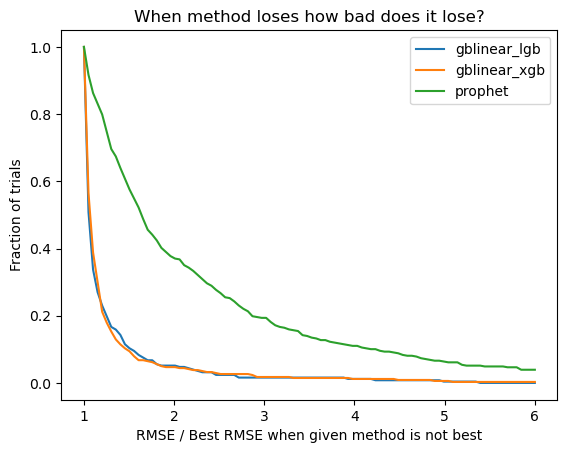

In [9]:
pd.options.display.max_rows=1000

rrr['min'] = rrr[cols].min(1)

def get_ratios(col):
    col_ratio = rrr[col] / rrr['min']

    xgrid = np.linspace(1,6, 100)
    
    res = []
    for x in xgrid:
        res.append({
            'x': x,
            'p': (col_ratio[rrr[col] > rrr['min']] > x).mean()
        })
    res = pd.DataFrame(res)
    return res



res = get_ratios('rmse_gblinear_lgb')
plt.plot(res['x'], res['p'], label='gblinear_lgb')

res = get_ratios('rmse_gblinear_xgb')
plt.plot(res['x'], res['p'], label='gblinear_xgb')

res = get_ratios('rmse_prophet')
plt.plot(res['x'], res['p'], label='prophet')

#plt.xscale('log')
#plt.yscale('log')
plt.legend()
plt.xlabel('RMSE / Best RMSE when given method is not best')
plt.ylabel('Fraction of trials')
plt.title('When method loses how bad does it lose?')